In [3]:
import pandas as pd
import regex as re
from tqdm import tqdm_notebook
import os
import shutil
import matplotlib.pyplot as plt
import artm
import codecs
from seaborn import heatmap
import time
from math import log
import operator
import numpy as np
from nltk import sent_tokenize
from pymystem3 import Mystem
from tools import *
from preprocess_line import CollocationSyntax, add_collocation, lemmatize
from create_ww_and_pmi_count import main as prepare_vw_wntm_pmi_vocab
import pickle
%matplotlib inline
tqdm_notebook().pandas(tqdm_notebook())

# Скраулим и распарсим [народные отзывы с banki.ru](http://www.banki.ru/services/responses/)

[Scrapy](https://scrapy.org/) - одна из наиболее популярных библиотек Python для получения данных с веб-страниц, которая включает в себя большинство общих функциональных возможностей.
Очень важным преимуществом библиотеки является её производительность, засчёт работы поверх асинхронного фреймворка. 

Работа с библиотекой обычно состоит из трех этапов:

- создание паука, выполняющего GET запросы,
- извлечение данные из HTML документа,
- парсинг и экспорт данных.

[Scrapy Tutorial](https://doc.scrapy.org/en/latest/intro/tutorial.html)

In [ ]:
import scrapy
import html2text


class BanksSpider(scrapy.Spider):
#     имя будет использоваться при вызове команды crawl
    name = "banks"
#     Зададим начальную страницу
    start_urls = [
        'http://www.banki.ru/services/responses/',
    ]
# Распарсим страницы с отзывами
    def parsePage(self, response):

        if response.status != 400:

            h = html2text.HTML2Text()
            h.ignore_links = True
            get_next = response.url.split("=")
            
            if len(get_next) > 1:
                current_number = int(get_next[-1])
            else:
                current_number = 1
                
            for index, item in enumerate(response.xpath('//*[contains(concat( " ", @class, " " ), \
                                                        concat( " ", "responses__item", " " ))]')):
                
                time = item.css("time.display-inline-block::text").extract_first()
                title = item.css("a.font-size-large::text").extract_first()
                rating = h.handle(item.css("div.responses__item__rating").extract_first()).strip()
                bank_response = item.css("div.thread-item__text").extract_first()
                if bank_response:
                    bank_response = h.handle(bank_response).strip()
                text = item.css("div.responses__item__message")
                if len(text) == 2:
                    text = h.handle(text[1].extract()).strip()
                else:
                    text = h.handle(text.extract_first()).strip()
                author = h.handle(item.css("div.responses__item__from").extract_first()).strip()
                comments_n = item.xpath('//a[contains(@href, "comments")]/text()')[index].extract()
                yield {
                    "bank": response.url.split("/")[6],
                    "time": time,
                    "title": title,
                    "rating": rating,
                    "bank_response": bank_response,
                    "text": text,
                    "author": author,
                    "comments_n": comments_n,
                    "comment_page": str(current_number)
                }
#             Добавим переход на следующую страницу    
            if current_number != 1:
                next_number = current_number + 1
                next_page = get_next[0] + "=" + str(next_number)
            else:
                next_page = response.url + "?page=2"
            yield scrapy.Request(next_page, callback=self.parsePage)
    
# Распарсим главную странцу и получим ссылки на страницы банков
    def parse(self, response):

        for bank in response.xpath("//script[contains(., 'banksData')]/text()").re(r'"code":"(.*?)"'):
            next_page = "http://www.banki.ru/services/responses/bank/" + bank
            yield scrapy.Request(next_page, callback=self.parsePage)


In [ ]:
os.system("scrapy startproject banksru")

Копируем код класса BanksSpider в banks_spider.py

В settings.py изменяем:

- **USER_AGENT = 'www.example.net'**
- **OBOTSTXT_OBEY = False ** --- игнорируем политику относительно поисковых роботов 

запускаем краулинг, ждем ...

Примерно через час ожидания, получаем banks.json размером ~ 4gb

In [ ]:
os.system("scrapy crawl banks -o banks.json")

Объявим необходимые константы

In [232]:
FOLDER_DATA = "data_mini/"
REPLIES = FOLDER_DATA + "replies.pkl"
SENTENCES_REPLIES = FOLDER_DATA + "sentences_replies.pkl"
PATH_JSON = "tutorial/banks.json"
FOLDER_BATCHES = FOLDER_DATA + 'batches/'
BRANCHES = FOLDER_DATA + "branches.pkl"
COLLOCATIONS = FOLDER_DATA + "collocations.txt"
SENTIMENT_PATH = FOLDER_DATA + "collection (docs&words)_2016_all_labels/full word_rating_after_coding.xlsx"

COLUMN_REPLY_ID = "reply_id"
COLUMN_VOCAB_ONLY = "vocab_only"
COLUMN_SENTENCE = "sentence"
COLUMN_DELETE_EXTRA_SYMBOLS = "deleted_extra_symbols"
COLUMN_LEMMATIZED = "lemmatized"
COLUMN_VOCAB_ONLY = "vocab_only"

SYNTAXNET_INPUT = FOLDER_DATA + "to_syntaxnet.txt"
SYNTAXNET_OUTPUT = FOLDER_DATA + "from_syntaxnet.txt"
SYNTAXNET_MODELS_PATH = "~/Python_libs/models/syntaxnet/syntaxnet"
SYNTAXNET_OUTPUT_PKL = "from_syntaxnet.pkl"

**Описание данных**:
* author ---  автор комментария
* bank --- название банка
* bank_response --- ответ банка на отзыв
* comment_page --- номера страницы с комментариями
* comments_n --- число комментариев к отзыву
* rating ---  оценка банку + статус
* text --- текс отзыва
* time --- время добавление отзыва
* title --- заголовок комментария

Число отзывов ~ 270k

Различных банков - 50

Временной период 2005 - 2017 года

In [3]:
replies = pd.read_json(PATH_JSON)

In [4]:
replies.comments_n[replies.comments_n == u"Комментировать"] = 0
replies.head()

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,author,bank,bank_response,comment_page,comments_n,rating,text,time,title
0,Андрей Валентинович,modulbank,"Андрей, здравствуйте! \nСпасибо за отзыв. Все...",1,0,оценка: 2 проверяется,"Зарегистрировав ИП, я решил открыть счет. \nЯ...",06.04.2017 4:53,Проблемы открытия счета
1,protection-tsk,modulbank,"Здравствуйте, Иван! \nСпасибо за отзыв и высо...",1,0,оценка: 5 проверяется,"Хотим отметить четкую, слаженную, работу менед...",05.04.2017 16:57,Благодарность
2,Ирина696,modulbank,"Ирина, здравствуйте! \n \nСпасибо за отзыв. ...",1,0,оценка: 3 проверяется,"Добрый день, столкнулась с такой ситуацией. З...",04.04.2017 15:40,Открытие счета
3,vulkan3,modulbank,"Здравствуйте, Максим! \n \nСпасибо за отзыв....",1,2,оценка: 1 проверяется,Перевел нечаянно в воскресенье деньги в налого...,04.04.2017 8:51,Ужасный банк
4,vroks,modulbank,Здравствуйте! \n \nСпасибо за отзыв. Ситуаци...,1,0,оценка: 2 проверяется,"Открыт счет в банке. \nНапример, кто-то решае...",03.04.2017 10:57,"Никак не получается поднять оценку банку, толь..."


Выделим оценку банка в отдельную колонку

In [5]:
def mark(line):
    value = re.sub(ur"[а-яА-Я: ]", "", line)
    return int(value) if value else -1
replies["mark"] = replies.rating.progress_apply(mark)

Посмотрим на число отзывов для каждого из банков. Количество отзывов сильно варьируется.

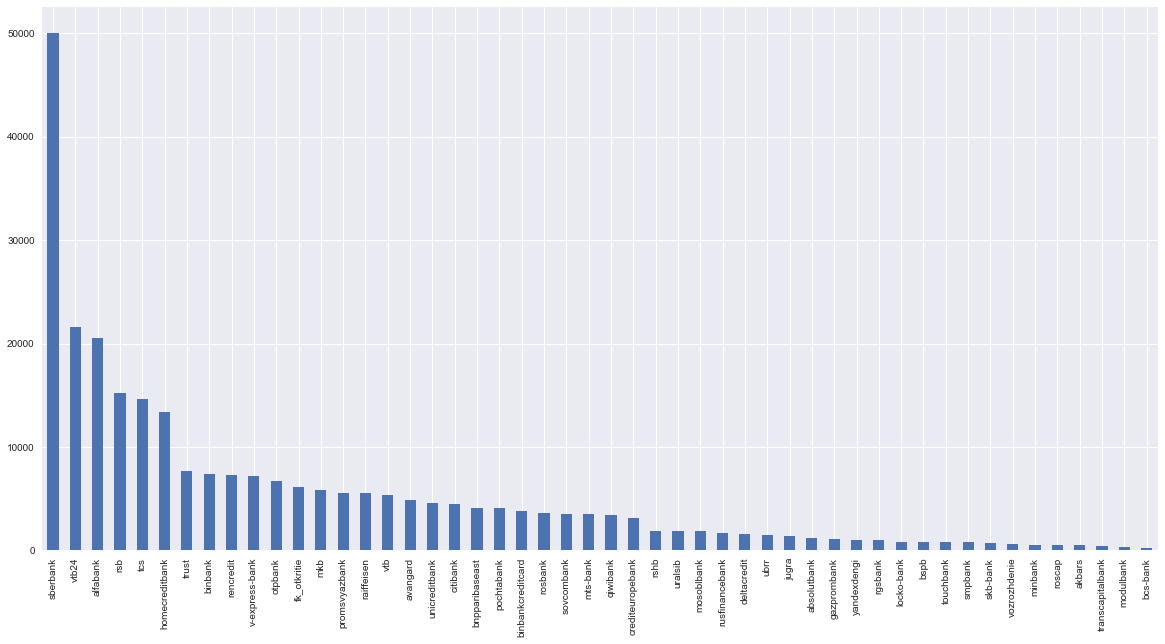

In [6]:
plt.figure(figsize=(20, 10))
replies.bank.value_counts().plot(kind="bar")

Посмотрим на распределение оценок по банкам

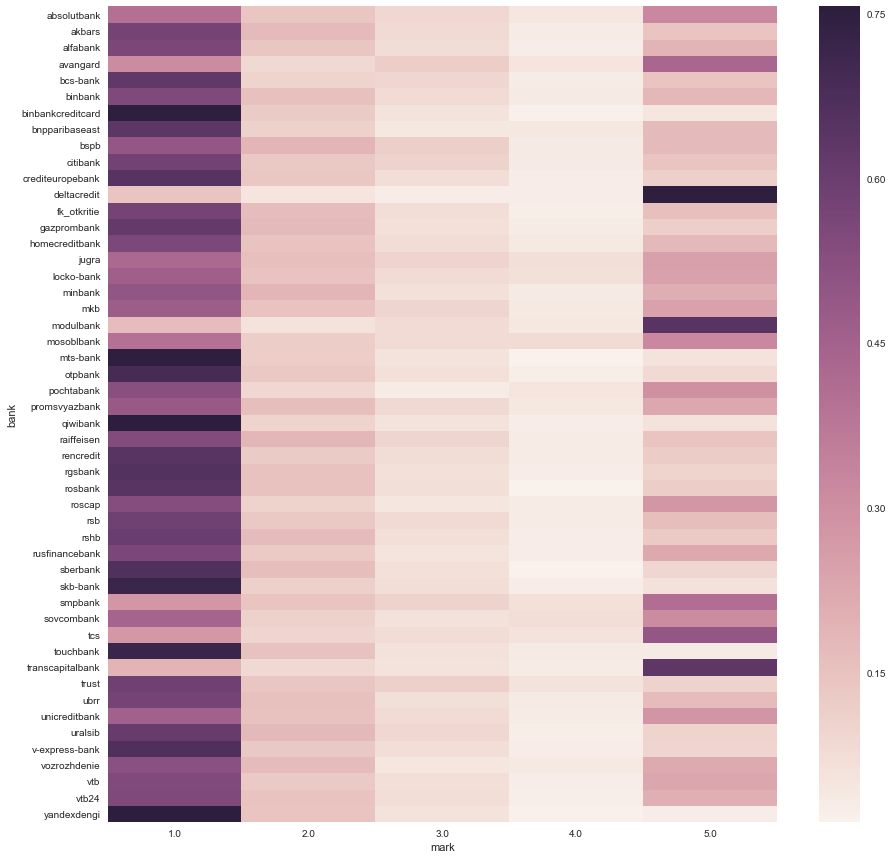

In [106]:
plt.figure(figsize=(15, 15))
heatmap(pd.crosstab(replies.bank, replies.mark[replies.mark != -1], normalize="index"))

Как часто пользователи пишут комментарии?

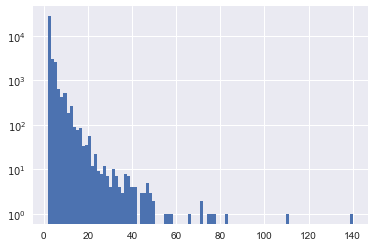

In [8]:
comment_frequency = replies.author.value_counts()
fig, ax = plt.subplots()
comment_frequency[comment_frequency > 1].hist(bins=100)
ax.set_yscale('log')

Большинство пользователей оставляет пару комментариев. Посмотрим отдельно на активных пользователей

In [13]:
pd.set_option("display.max_rows", 100)
replies[replies.author.isin(comment_frequency[comment_frequency > 50].index)].groupby(
    ["author", "bank"])["mark"].value_counts().unstack(fill_value=0).head(50)

mark                          -1   1   2   3   4   5
author     bank                                     
Complince  absolutbank         0   0   0   0   0   2
           alfabank            0   3   0   1   0   5
           avangard            0   5   0   3   0   5
           binbank             0   0   0   1   0   0
           binbankcreditcard   0   0   0   0   0   1
           citibank            0  12   0   3   0   5
           crediteuropebank    0   5   0   1   0   2
           deltacredit         0   2   0   0   0   1
           fk_otkritie         0   1   0   1   0   3
           gazprombank         0   2   0   0   0   0
           homecreditbank      0   5   0   0   0   0
           minbank             0   1   0   0   0   0
           mkb                 0   0   0   0   0   2
           mts-bank            0   1   0   0   0   2
           otpbank             0   0   0   0   0   1
           promsvyazbank       0   1   0   0   0   1
           raiffeisen          1   2   0   0   0   2
           rencredit           0   2   0   1   0   2
           rosbank             0   1   0   1   0   1
           roscap              0   0   0   0   0   1
           rsb                 3   9   0   5   0   3
           sberbank            0   2   0   0   0   7
           unicreditbank       0   2   0   0   0   6
           vtb                 1   3   0   1   0   2
           vtb24               0   2   0   0   0   2
Helenspb78 akbars              1   0   0   0   0   0
           alfabank           11   7   1   0   0   0
           citibank            2   0   0   0   0   0
           homecreditbank      0   0   1   0   0   0
           mts-bank            0   1   0   0   0   0
           rencredit           2   4   1   0   0   0
           rsb                43   7   2   6   2   5
           sberbank            9   3   1   0   0   0
           unicreditbank       0   1   0   0   0   0
           v-express-bank      1   0   0   0   0   0
VIPservis  alfabank            3   3   0   0   0   0
           mts-bank            4   2   0   0   0   0
           promsvyazbank       1   3   0   0   0   0
           rencredit           3   2   1   0   0   0
           sberbank            8   3   0   0   0   0
           tcs                 7   4   1   0   0   1
           unicreditbank       1   0   0   0   0   0
           uralsib             0   1   0   0   0   0
           v-express-bank      0   1   0   0   0   0
           vtb                 1   3   0   0   0   0
           vtb24               1   3   0   0   0   1
lauger     alfabank            3   0   0   0   0   1
           avangard            0   0   0   0   0   1
           binbank             1   0   1   0   1   1
           fk_otkritie         4   2   0   0   0   1

Было бы интересно посмотреть на пользователей, которые поставили противоричивые отзывы об одном банке?

Сильно ли отличаются даты этих комментариев? (Может банк решил проблему или же наоборот стало хуже с обслуживанием)

Используют ли пользователи сайта одновременно несколько банков?

Можно ли судить об оттоке пользователей если проанализировать динамику оценок во времени?

Число уникальных ответов банка. В чем причина не уникальности ответов банка?

In [14]:
print "Уникальных {} ответов из {}".format(len(replies.bank_response.unique()), len(replies.bank_response))

Уникальных 168961 ответов из 266439


Практически все отзывы уникальные. Пользователи копируют отзывы в случае когда хотят донести до банка некоторую проблему.

In [15]:
print "Уникальных {} отзывов из {}".format(len(replies.text.unique()), len(replies.text))
print "\n\n".join(replies.text.value_counts().index[:3])

266299 266439
Здравствуйте, я являюсь руководителем организации. Так как мой работник был
уволен по соглашению сторон в январе 2015 года, прошу Вас удалить рабочие
телефоны 83916938173, 83916936256. Вы мешаете нашей работе! Ни о какой личной
явке к вам в ваш офис не может быть речи, так как никаких обязательств перед
вами наша организация не имеет. В противном случае я вынуждена буду обратиться
в Прокуратуру, ЦБ РФ и другие контролирующие вас организации.

Здравствуйте. Я - Мартынова Нина Григорьевна. Клиентом Вашего банка является
мой сын - Мартынов Андрей Петрович, проживающий по адресу : Ростовская
область, г. Батайск, ул. Луначарского, дом **. Как я поняла из регулярного
общения с Вашими сотрудниками - у него образовались просрочки платежей. Теперь
мне постоянно звонят на домашний телефон : 8 86354 94163 по вопросу погашения
кредита моего сына, если быть точнее – с требованием оплатить за него
задолженность. Я со своим сыном связь не поддерживаю, живём мы раздельно и
платить за нег

Заметим, что в отзывах есть лишние символы конца строки, удалим их.

In [16]:
replies.text = replies.text.apply(lambda line: re.sub(u'\n', u' ', line))

Заголовки отзывов довольно часто повторяются.

In [17]:
replies.title.value_counts()[:10]

Благодарность             1703
Претензия                  672
Жалоба                     575
Кредитная карта            532
Звонки из банка            417
Отличный банк              414
Телефонный терроризм       352
Хороший банк               338
Потребительский кредит     314
Реструктуризация           301
Name: title, dtype: int64

Разделим отзывы на предложения.

In [18]:
sentences = []
replies_id = []
for index, reply in tqdm_notebook(replies.text.iteritems()):
    current_sentences = sent_tokenize(reply)
    sentences += current_sentences
    replies_id += [index]*len(current_sentences)
    
sentences_replies = pd.DataFrame()
sentences_replies[COLUMN_SENTENCE] = sentences
sentences_replies[COLUMN_REPLY_ID] = replies_id

# Предобработка данных

**Успех зависит на 80%(с потолка) от качества предобработка данных.**

В силу того что естественный язык содержит много шумовой информации, очень важно сделать качественную предобработку данных.

В данном эксперименте:
* удалим специальные символы
* удалим низкочастотные слова
* лемматизируем текст
* проведем синтаксический разбор
* отфильтруем слова по частям речи
* выделим устойчивые словосочетания (коллокации)

## Очистим данные от специальных символов

Оставим лишь буквы русского языка, приведем к нижнему регистру.

In [26]:
def deleteExtraSymbols(line):
    if line:
        return re.sub(' +',' ', re.sub(ur'[^А-Яа-я ]', u' ', line).lower().rstrip().strip())
    else:
        return None

In [27]:
sentences_replies[COLUMN_DELETE_EXTRA_SYMBOLS] = sentences_replies.sentence.progress_apply(deleteExtraSymbols)

Удалим пустые строки

In [96]:
sentences_replies = sentences_replies[sentences_replies.vocab_only != ""]

Сохраним данные

In [101]:
sentences_replies.to_pickle(SENTENCES_REPLIES)
replies.to_pickle(REPLIES)

Загрузим данные

In [ ]:
#sentences_replies = pd.read_pickle("sentences_replies.pkl")
#replies = pd.read_pickle("replies.pkl")

In [7]:
sentences_replies = pd.read_pickle(SENTENCES_REPLIES)

In [8]:
replies = pd.read_pickle(REPLIES)

## Синтаксический анализ

Подготовим входные данные для SyntaxNet

In [103]:
with codecs.open(SYNTAXNET_INPUT, "w", encoding="utf-8") as output:
    print >> output, "\n".join(sentences_replies.deleted_extra_symbols[sentences_replies.vocab_only != ""])

### Проведем синтаксический анализ предложений

[SyntaxNet](https://github.com/tensorflow/models/tree/master/syntaxnet) - инструмент для синтаксического разбора. 

Для сборки SyntaxNet из исходников требуется 12gb RAM. В случае нехватки ресурсов можно воспользоваться [Docker image](https://hub.docker.com/r/evgenysmirnov/syntaxnet/).

#### SyntaxNet установлен локально

In [ ]:
start_time = time.time()
if os.system("./run_syntaxnet.sh {} {} {}".format(SYNTAXNET_INPUT, SYNTAXNET_OUTPUT, SYNTAXNET_MODELS_PATH)) != 0:
    print ERROR_MESSAGE
print "It took {:.2f} seconds".format(time.time() - start_time)

#### Docker образ

In [ ]:
start_time = time.time()
if os.system("docker run -v $(pwd)/{}:/data evgenysmirnov/syntaxnet".format(FOLDER_DATA)) != 0:
    print ERROR_MESSAGE
print "It took {:.2f} seconds".format(time.time() - start_time)

## Обработаем выход SyntaxNet:
* Селекция столбцов
* Именование столбцов
* Добавим колонку с лематизированным словами
* Индексация с нуля


**Лемматизация** — процесс приведения слова к нормальной форме.

В русском языке нормальными формами считаются следующие морфологические формы:

* для существительных — именительный падеж, единственное число;
* для прилагательных — именительный падеж, единственное число, мужской род;
* для глаголов, причастий, деепричастий — глагол в инфинитиве.

Более того, заменим все имена одним токеном "имя".

**Библиотеки для лемматизации**:
* pymorphy2 (русский)
* mystem3 (русский)
* Wordnet Lemmatizer (NLTK, язык английский, требует POS метку)
* Metaphraz (язык русский)
* Coda/Cadenza (языки русский и английский)

**Примеры лемматизации:**
- живу -> жить
- здравструйте -> здравствовать
- положительная -> положительный
- ип -> ипать

In [ ]:
from process_assessors_topics import syntaxnet_post_process
from_syntaxnet = syntaxnet_post_process(SYNTAXNET_OUTPUT)
from_syntaxnet.to_pickle(SYNTAXNET_OUTPUT_PKL)

In [10]:
from_syntaxnet.head(10)

,word_id,word,parent_id,tag,dependency,sentence_id,lemmatized
0,0,зарегистрировав,3,VERB,advcl,0,зарегистрировать
1,1,ип,0,NOUN,dobj,0,ипать
2,2,я,3,PRON,nsubj,0,я
3,3,решил,-1,VERB,ROOT,0,решать
4,4,открыть,3,VERB,xcomp,0,открывать
5,5,счет,4,NOUN,dobj,0,счет
6,0,я,1,PRON,nsubj,1,я
7,1,живу,-1,VERB,ROOT,1,жить
8,2,в,3,ADP,case,1,в
9,3,хабаровске,1,NOUN,nmod,1,хабаровск


## Соберем словарь коллекции

**Словарь** --- множество уникальных слов в коллекции

Посчитаем частоты слов в корпусе

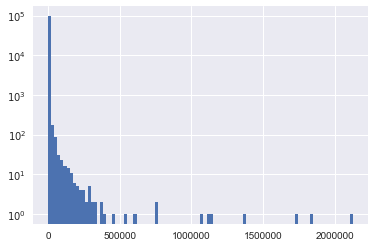

In [4]:
word_frequency = dict()
for word in tqdm_notebook(from_syntaxnet.lemmatized):
    if word in word_frequency:
        word_frequency[word] += 1
    else:
        word_frequency[word] = 1
plt.hist(word_frequency.values(), bins=100)
plt.yscale("log")

Фоновая лексика содержится в высокочастотных словах

In [5]:
for word, frequency in word_frequency.iteritems():
    if frequency > 500000:
        print word

по
быть
и
что
в
не
на
банк
я
с
карта


Низкочастотные слова довольно часто содержат опечатки, логины автором и прочие малозначимые сущности

In [8]:
rare_words = [key for key, value in word_frequency.iteritems() if value < 70]
print " ".join(np.random.choice(rare_words, 50))

дельтакрдит домовой прводиться печенюшка диковато журавковый тожен фальшифок воросвство вазомоторика внутриигровой судный покудо онайн незрячий металлсервис испектор нормальое узда сибанк приглушенный новоуральский плетка вакульчик оганизация недоуказывать беспризорная бордюр добродушно маяться приспешник жлоб репост ненатуральный местопребывание теперяча емежесячный файр скупка ниужели клаустрофобия многонедельный раушский произходить плетень изобильный рахов ствндарт заносчивый опред


Удалим низкочастотные слова, так как они не внесут статистической силы, а лишь увеличат потребление ресурсов

Отобрано 11109 слов из 97173


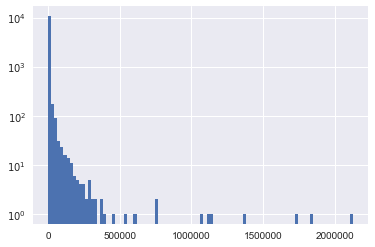

In [9]:
word_frequency_selected = {word: frequency for word, frequency in word_frequency.iteritems() if frequency > 70}
print "Отобрано {} слов из {}".format(len(word_frequency_selected), len(word_frequency))
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(word_frequency_selected.values(), bins=100)
plt.yscale("log")

In [10]:
vocab = set(word_frequency_selected.keys())

## Выделение синтаксических веток в дереве
Синтаксическая ветка --- последовательность слов от корня дерева до любого из его листьев.

Оствавим в коллекции лишь слова из словаря.

Сделаем фильтрацию по частям речи.

In [11]:
from Branches import *
branches = Branches(vocab=vocab, bad_tags={u'ADP', U'CONJ', U'AUX', U'PRON', U'NUM', U'SCONJ'})

Получим синтаксические ветки из дерева синтаксического разбора. 

Для каждой пары частей речи составим словарь частот соответствующих им словосочетаний (**addTags**).

In [12]:
branches.addDataFrame(from_syntaxnet, addTags=True, save_global_ids=False, save_local_ids=False)

word 57070000 from 57079694

In [25]:
branches_data = branches.outputData.getDataFrame()
branches_data.to_pickle(BRANCHES)
print "\nЧисло веток - {}".format(len(branches_data))
branches_data.head(10)


Число веток - 19413628


,sentence_id,branch_id,branch
0,0,0,решать зарегистрировать ипать
1,0,1,решать открывать счет
2,1,0,жить хабаровск
3,2,0,сказать позвонить март
4,2,1,сказать позвонить банк
5,2,2,сказать можно открывать счет
6,2,3,сказать можно открывать хабаровск
7,3,0,отправлять спокойно март
8,3,1,отправлять ч
9,3,2,отправлять сайт банк


In [41]:
branches.dump_dictionaries(FOLDER_DATA)

### Отбор терминов

Для отбора терминов используем трехэтапный метод фильтрации:
* синтаксическая связность
* высокая частотность
* высокий pmi

In [26]:
# вычислим n_uv
def getWordsCounts(pair_dictionary):
    n_words = dict()
    for pair in pair_dictionary:
        word1, word2 = pair
        if word1 in n_words:
            n_words[word1] += 1
        else:
            n_words[word1] = 1
        if word2 in n_words:
            n_words[word2] += 1
        else:
            n_words[word2] = 1
    return n_words

def filter_pairs(pairs, threshold_frequency, threshold_pmi):
    pairs_sorted = sorted(pairs.items(), key=operator.itemgetter(1), reverse=True)
    n_words = getWordsCounts(pairs)
    n_total = sum(n_words.values())
    new_elements = []
    for element in pairs_sorted:
        word1, word2 = element[0]
        n_pair = element[1]
        if n_pair > threshold_frequency:
            pmi = log(float(n_pair) / n_words[word1] / n_words[word2] * n_total)
            if pmi > threshold_pmi:
                new_elements.append(((" ".join(element[0])), n_pair, pmi))
    return new_elements

Отфильтруем по частоте и pmi и запишем на диск для дальнейшего анализа, группируя по парам частей речи.

In [30]:
FOLDER_COLLOCATION = FOLDER_DATA + "collocations/"

checkDirectory(FOLDER_COLLOCATION)
        
for key, pairs in tqdm_notebook(branches.dictionary_pairs.iteritems()):
    elements = filter_pairs(pairs, 300, 9)
    if elements:
        
        output = []
        for element in elements:
            output.append(u"{}: {} {:2}".format(element[0], element[1], element[2]))
                
        with codecs.open("{}{}.txt".format(FOLDER_COLLOCATION, key), "w", encoding="utf-8") as ouputFile:
            print >> ouputFile, "\n".join(output)

После анализа, сформируем словарь коллокаций.

In [33]:
collocations = []
for file_name in os.listdir(FOLDER_COLLOCATION):
    if not file_name.startswith("."):
        with codecs.open(FOLDER_COLLOCATION + file_name, encoding="utf-8") as input_file:
            collocations += [line.split(":")[0] for line in input_file.read().splitlines()]
with codecs.open(COLLOCATIONS, "w", encoding="utf-8") as output_file:
    print >> output_file, "\n".join(collocations)
print "Выделено коллокаций - {}".format(len(collocations))

Выделено коллокаций - 1325


Найдем все вхождения коллокаций и объединим слова в них нижним подчеркиванием.

**Пример:**
- карта кредитный -> карта_кредитный
- положительный решение -> положительное_решение

In [34]:
collocations = []

for collocation in getListFromFile(COLLOCATIONS):
    collocations.append(CollocationSyntax(collocation))
    
collocations_n = len(collocations)
    
all_branches = "\n".join(list(branches_data.branch))
    
for collocation in tqdm_notebook(collocations):
    all_branches = add_collocation(all_branches, collocation)
branches_data.branch = all_branches.split("\n")

Сохраним данные на диск

In [37]:
branches_data.to_pickle(BRANCHES)

## Преобразование данных в формат Vowpal Wabbit

Vowpal Wabbit базируется на следующих принципах:

* каждый документ записывается в одну строку
* все токены представлены в строковом формате (не требуется делать токенизацию)
* стадартная частота токенов = 1.0, чтобы ее изменить нужно указать ее значения после символа через двоеточие
* модальность токена идентифицируется символом (|)

#### Формат данных:
** `[<title>] [|@modality_class] {token[:counter]}` **

[Форматы входных данных](http://bigartm.readthedocs.io/en/stable/tutorials/datasets.html)

### Документ = предложение

**Пример строк входного файла:**

0  |@default_class когда:5 долгий:1 разница:1 спокойно:2 один:2 возможный:1 неизвестно:1

20  |@default_class перев:3 испробовать:1 деньги:3 сказать:1 открывать:1 один:1 первый:1

Нам потребуются два типа документов: отзыв, предложение.

Предложения будем формировать как объединение слов соответствующих ему синтаксических веток. Тем самым мы отнормируем вес слов в зависимости от их синтаксической значимости.

In [ ]:
current_sentence_id = branches_data.loc[0].sentence_id
current_vw = dict()
sentences = dict()
sentences_replies_indexes = list(sentences_replies.index)

for _, row in tqdm_notebook(branches_data[["sentence_id", "branch"]].iterrows()):
    sentence_id = row.sentence_id
    branch = row.branch
    
    if sentence_id != current_sentence_id:
        sentences[sentences_replies_indexes[current_sentence_id]] = current_vw
        current_vw = dict()
        current_sentence_id = sentence_id
        
    for word in branch.split():
        if word in current_vw:
            current_vw[word] += 1
        else:
            current_vw[word] = 1
sentences[sentences_replies_indexes[current_sentence_id]] = current_vw
sentences_replies["vw"] = pd.Series(sentences)

In [91]:
sentences_replies.to_pickle("sentences_replies.pkl")

Преобразуем временную метку в формат pandas.datetime

In [15]:
replies.time = pd.to_datetime(replies.time)

### Данных действительно много, поэтому для туториала оставим лишь отзывы начиная с 1 января 2017 года

In [26]:
replies_mini = replies[replies.time > pd.to_datetime("2017-01-01 00:00:00")]
print "{} отзывов с 1 января 2017 года".format(len(replies_mini))

16375 отзывов с 1 января 2017 года


In [27]:
sentences_replies_mini = sentences_replies[sentences_replies.reply_id.isin(replies_mini.index)]
print "{} предложений в отзывах с 1 января 2017 года".format(len(sentences_replies_mini))

235479 предложений в отзывах с 1 января 2017 года


In [42]:
branches_data_mini = branches_data[branches_data.sentence_id.isin(sentences_replies_mini.index)]
print "Осталось {} синтаксических веток".format(len(branches_data_mini))

Осталось 1091638 синтаксических веток


In [43]:
replies_mini.to_pickle(REPLIES)
sentences_replies_mini.to_pickle(SENTENCES_REPLIES)
branches_data_mini.to_pickle(BRANCHES)

### Загрузим данные и начнем работу

In [44]:
replies = pd.read_pickle(REPLIES)
sentences_replies = pd.read_pickle(SENTENCES_REPLIES)
branches_data = pd.read_pickle(BRANCHES)

In [45]:
output_vw = []
for index, vw_dict in tqdm_notebook(sentences_replies.vw.dropna().iteritems()):
    sentence = [u"{}:{}".format(word, frequency) for word, frequency in vw_dict.iteritems()]
    output_vw.append(u"{} |@default_class {}".format(index, " ".join(sentence)))
    
with codecs.open(FOLDER_DATA + "vw_sentences.txt", "w", encoding="utf-8") as output:
    print >> output, "\n".join(output_vw)

## Документ = отзыв

In [46]:
output_vw = []
current_reply_id = sentences_replies.loc[0].reply_id
reply_words = dict()

for _, row in tqdm_notebook(sentences_replies[["vw", "reply_id"]].dropna().iterrows()):
    vw_dict = row["vw"]
    reply_id = row["reply_id"]
    
    if reply_id != current_reply_id:
        reply = [u"{}:{}".format(word, frequency) for word, frequency in reply_words.iteritems()]
        output_vw.append(u"{} |@default_class {}".format(current_reply_id, " ".join(reply)))
        reply_words = dict()
        current_reply_id = reply_id
        
    for word, frequency in vw_dict.iteritems():
        if word in reply_words:
            reply_words[word] += frequency
        else:
            reply_words[word] = frequency
reply = [u"{}:{}".format(word, frequency) for word, frequency in reply_words.iteritems()]
output_vw.append(u"{} |@default_class {}".format(current_reply_id, " ".join(reply)))
            
with codecs.open(FOLDER_DATA + "vw_replies.txt", "w", encoding="utf-8") as output:
    print >> output, "\n".join(output_vw)

## VW для своего словаря тональностей*

In [47]:
output_vw = []
current_reply_id = sentences_replies.loc[0].reply_id
reply_words = dict()
sentiment_indexes = list(replies[replies.mark != -1].index)
sentences_replies_sentiment = sentences_replies[sentences_replies.reply_id.isin(sentiment_indexes)]

for _, row in tqdm_notebook(sentences_replies_sentiment[["vw", "reply_id"]].dropna().iterrows()):
    vw_dict = row["vw"]
    reply_id = row["reply_id"]
    
    if reply_id != current_reply_id:
        reply = [u"{}:{}".format(word, frequency) for word, frequency in reply_words.iteritems()]
        output_vw.append(u"{} |@default_class {}".format(current_reply_id, " ".join(reply)))
        reply_words = dict()
        current_reply_id = reply_id
        
    for word, frequency in vw_dict.iteritems():
        if word in reply_words:
            reply_words[word] += frequency
        else:
            reply_words[word] = frequency
reply = [u"{}:{}".format(word, frequency) for word, frequency in reply_words.iteritems()]
output_vw.append(u"{} |@default_class {}".format(current_reply_id, " ".join(reply)))
            
with codecs.open(FOLDER_DATA + "vw_sentiment.txt", "w", encoding="utf-8") as output:
    print >> output, "\n".join(output_vw)

## WNTM псевдо-документы

абсурдный |@default_class абсолютно:8 авангард:1 адрес:5 альфа:1 аргумент:1 аргументировать:1 ассоциироваться:1 банк:22 банкомат:1 безобразие:1 бесплатный:2 

сопротивляться |@default_class активно:2 анкета:1 аннулирование:1 аргумент:1 банк:21 барышня:1 блокировка:1 более:2 брать:1 бухгалтер:1 бы:2 быдло:2 быть:7 ведь:1 вежливость:1

Входные аргументы:
- **lines** - список строк
- **output_dir** - куда положить выходные данные
- **window** - ширина окна

в **output_dir** будут:
- **vw_ww.txt** - псевдо-документы в vw формате
- **pmi.txt** - счетчики совстречаемости
- **vocab.txt** - словарь коллекции

In [48]:
prepare_vw_wntm_pmi_vocab(lines=branches_data.branch, output_dir=FOLDER_DATA, window=5)

100%|██████████| 1091638/1091638 [00:16<00:00, 65832.54it/s]


save wv to data_mini/ww_vw.txt



100%|██████████| 2500108/2500108 [00:05<00:00, 468133.63it/s]


save vocab to data_mini/vocab.txt

116 from 11933

6578 from 11933

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.


11846 from 11933
Time elapsed: 81.872 sec.


# Тематическое моделирование
BigARTM &ndash; открытая библиотека для тематического моделирования текстовых коллекций, реализующая теорию аддитивной регуляризации тематических моделей (ARTM). Основной сайт проекта http://bigartm.org/.

#### Цель экспериментов:
Выявить тематическую структуру отзывов и определить их тональности.

#### Описание
Построим тематические модели для отзывов и WNTM для коротких текстов. Проведем анализ тональности тем.

## Документ = отзыв
В данной группе экспериментов будем счить каждый отзыв отдельным документом

In [49]:
PATH_TO_VW_REPLIES = FOLDER_DATA + 'vw_replies.txt'
FOLDER_BATCHES_REPLIES = FOLDER_BATCHES + "replies"
PMI_PATH = FOLDER_DATA + "pmi.txt"
VOCAB_PATH = FOLDER_DATA + "vocab.txt"

В Python API, по аналогии с алгоритмами из scikit-learn, входные данные представлены одним классом BatchVectorizer. Объект этого класса принимает на вход батчи или файлы UCI / VW и подаётся на вход всем методам. В случае, если входные данные не являются батчами, он создаёт их и сохраняет на диск для последующего быстрого использования.

Итак, создадим объект [BatchVectorizer](http://bigartm.readthedocs.io/en/stable/api_references/python_interface/batches_utils.html):


In [56]:
checkDirectory(FOLDER_BATCHES_REPLIES)
bv = artm.BatchVectorizer(data_path=PATH_TO_VW_REPLIES, data_format="vowpal_wabbit",
                          target_folder=FOLDER_BATCHES_REPLIES, gather_dictionary=True)

В ARTM темы принято разделять на два непересекающихся подмножества — предметных и фоновых тем. **Предметные темы** состоят из терминов предметных областей, а **фоновые темы** из слов общей лексики. Более того, будем выделять темы отражающие положительную и отрицательную тональности.

In [57]:
def createTopics(domain_n=90, background_n=10, sentiment=False):
    global DOMAIN_N, BACKGROUND_N, string_id
    DOMAIN_N = domain_n
    BACKGROUND_N =  background_n
    string_id = "d{}_b{}".format(domain_n, background_n)
    global topics_background, topics_domain, topics_sentiment
    topics_domain = ['topic_d{}'.format(i) for i in xrange(domain_n - 2)]
    if sentiment:
        topics_sentiment = ['topic_pos', 'topic_neg']
    else:
        topics_domain += ['topic_d{}'.format(i) for i in xrange(domain_n - 2, domain_n)]
    
    topics_background = ['topic_b{}'.format(i) for i in xrange(background_n)]

Выбор числа тем - открытая проблема в тематическом моделировании, как и метод выбора числа кластеров в задачах кластеризации. Число тем выберем основываясь на размере коллекции.

In [126]:
createTopics(domain_n=100, background_n=10)

Следующий шаг — инициализация моделей. Сделаем это по словарю, что означает, что
- будет создана матрица $\Phi$ с именем 'pwt', число строк и столбцов в ней будет взято исходя из числа слов в словаре и заданного в модели числа тем;
- эта матрица будет заполнена случайными значениями из диапазона **(**0, 1) и нормализована.

Словарь &ndash; это объект BigARTM, содержащий информацию о коллекции (словарь коллекции, различные величины и счётчики, связанные со словами). Создать словарь можно на основе папки с батчами. Затем собранный словарь можно сохранять на диск и позже подгрузить вновь.
[ARTM_model](http://bigartm.readthedocs.io/en/stable/api_references/python_interface/artm_model.html)

Если матрица $\Theta$ слишком большая, то следует выставить cache_theta=False, reuse_theta=False и изменить число проходов по документу num_document_passes=10. Так как матрица $\Theta$ не хранится в памяти, то BigARTM будет делать несколько итераций чтобы "получить ее по частям".

In [127]:
model = artm.ARTM(topic_names=topics_domain + topics_background, dictionary=bv.dictionary, 
                  theta_columns_naming="title", num_document_passes=1, cache_theta=True, reuse_theta=True)

Основным функционалом качества является перплексия коллекции. Однако это не иденственный функционал качества. Будем смотреть на следюущие характеристики тематической модели:
- разреженность матрицы $\Phi$ (слова-темы); 
- разреженность матрицы $\Theta$ (темы-документы);
- характеристики ядер тем (чистота, контрастность, размер);
- когерентность $\mathsf{PMI}_t =\frac{2}{k(k-1)} \sum_{i=1}^{k-1} \sum_{j=i}^k \mathsf{PMI} (w_i,w_j)$

[Метрики качества](http://bigartm.readthedocs.io/en/stable/tutorials/scores_descr.html)

In [128]:
def add_scores(model):
    model.scores.add(artm.PerplexityScore(name='PerplexityScore',
                                                  dictionary=cooc_dict))
    model.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore', topic_names=topics_domain))
    model.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore', topic_names=topics_domain))
    model.scores.add(artm.TopicKernelScore(name='TopicKernelScore',
                                           topic_names=topics_domain, probability_mass_threshold=0.3))
    model.scores.add(artm.TopTokensScore(name='TopTokensScore',
                                         num_tokens=50, dictionary=cooc_dict))

Соберем словарь совстречаемостей для подсчета когерентности тем:

In [129]:
cooc_dict = artm.Dictionary()
cooc_dict.gather(data_path=FOLDER_BATCHES_REPLIES, cooc_file_path=PMI_PATH, vocab_file_path=VOCAB_PATH)

Для оценки качества будем смотреть на графики метрик качества в зависимости от итерации.

In [130]:
def plot(model, savefig=False):
    x = range(len(model.score_tracker['PerplexityScore'].value[1:]))
    fig, ax1 = plt.subplots(figsize=(8, 6))
    ax1.plot(x, model.score_tracker['PerplexityScore'].value[1:], 'g-', linewidth=2, label="Perplexity")
    ax1.set_xlabel('Iterations count')
    ax1.set_ylabel('Perplexity', color='g')
    ax2 = ax1.twinx()
    ax2.plot(x, model.score_tracker['SparsityPhiScore'].value[1:], 'r*', linewidth=2, label="Phi sparsity")
    ax2.plot(x, model.score_tracker['SparsityThetaScore'].value[1:], 'r--', linewidth=2, label="Theta sparsity")
    ax2.set_ylabel('Ratio', color='r')
    ax2.legend(bbox_to_anchor=(1.10, 1), loc=2, borderaxespad=0.)
    plt.grid(True)
    if savefig:
        fig.savefig(FOLDER_DATA + 'convergence{}_{}.eps'.format(DOMAIN_N, BACKGROUND_N), bbox_inches='tight')
    
    x = range(model.num_phi_updates)[1:]
    fig, ax1 = plt.subplots(figsize=(8, 6))
    ax1.plot(x, model.score_tracker['TopTokensScore'].average_coherence[1:], 'g-', linewidth=2, label="size")
    ax1.set_xlabel('Iterations count')
    ax1.set_ylabel('Coherence top50', color='g')
    ax2 = ax1.twinx()
    ax2.plot(x, model.score_tracker['TopicKernelScore'].average_contrast[1:], 'r*', linewidth=2, label="contrast")
    ax2.plot(x, model.score_tracker['TopicKernelScore'].average_purity[1:], 'r--', linewidth=2, label="purity")
    ax2.set_ylabel('Ratio', color='r')
    ax2.legend(bbox_to_anchor=(1.10, 1), loc=2, borderaxespad=0.)
    plt.grid(True)
    if savefig:
        fig.savefig(FOLDER_DATA + 'interpretability{}_{}.eps'.format(DOMAIN_N, BACKGROUND_N), bbox_inches='tight')
    plt.show()
    plt.clf()

Для оценки **интерпретируемости** тем будем смотреть на топ-токены.

In [131]:
def printTopics(model, topics, num=70, print_file=False):
    phi = model.get_phi()
    zeros = 0
    string_to_print = ""
    for i, topic in enumerate(topics):
        topicSeries = phi[topic].sort_values(ascending=False)[:num]
        indexes = topicSeries > 0
        result = topicSeries[indexes].index
        string_to_print += topic + ":[{}/{}] ".format(len(result), sum(phi[topic] > 0)) + " ".join(result) + "\n"
        zeros += len(result) == 0
    print string_to_print
    if print_file:
        with codecs.open(FOLDER_DATA + 'topics_d{}_b{}.txt'.format(DOMAIN_N, BACKGROUND_N), 'w', 'utf8') as outputFile:
            print >> outputFile, string_to_print

In [132]:
add_scores(model)

Сделаем 10 итераций алгоритма

In [133]:
model.fit_offline(batch_vectorizer=bv, num_collection_passes=10)

График перплексии показывает, что модель еще не сошлась.

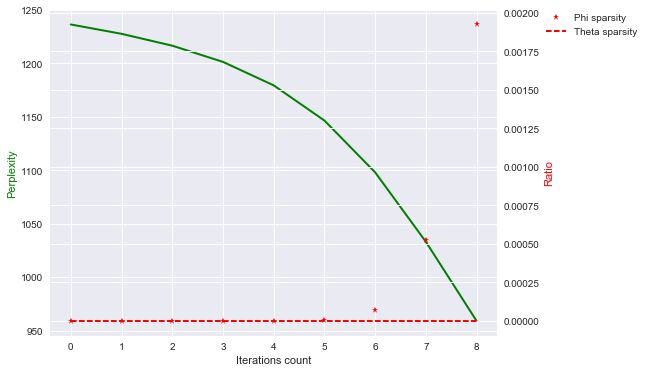

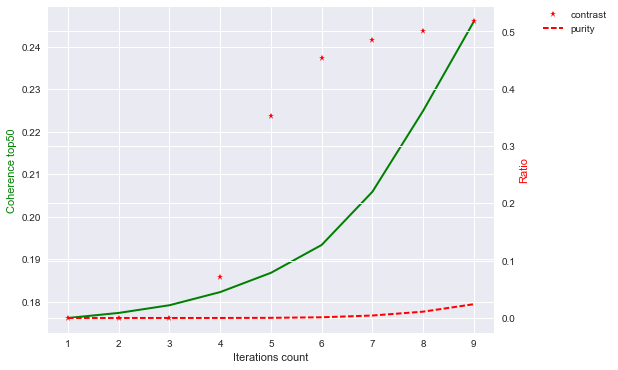

In [134]:
plot(model)

Сделаем еще 25 итераций

In [135]:
# сделать 25 итераций модели

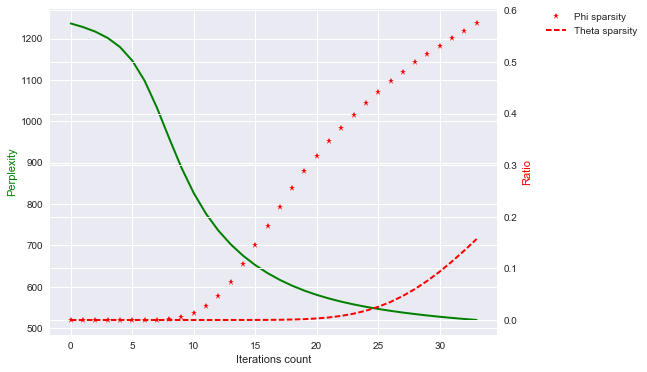

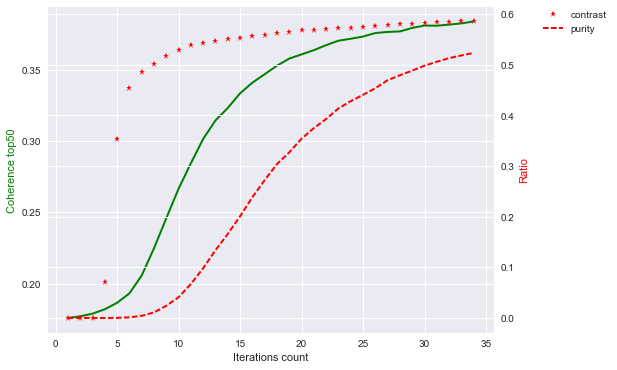

In [136]:
plot(model)

In [137]:
printTopics(model, topics_domain + topics_background)

topic_d0:[70/5101] обнаруживать то исправлять видно банк карта ошибка кабинет интернет лимит операция возможность реквизит доступный использование приводить личный ограничивать не тот пополнение проблема баланс это взимать сч онлайн информация поддержка снижать клиент выписка рубль расч система ситуация подтверждение послужить транзакция такой устанавливать данный другой технический проведение момент мой оператор ограничение служба просматривать овердрафт сумма соответствовать платеж также и запись списание платежный случай счет же факт косяк один код т известный значиться
topic_d1:[70/4882] банкомат деньги сбой карта внесение наличный не вставлять купюра средство касса расстраивать исчезать терминал чек операция прием сумма технический кассир рубль вынуждать вносить день ул денежный зачисление случай инкассация претензия работа экран адрес г пересчитывать время банк надпись располагать отделение зачисляться сломаться свой забирать данный проглатывать это оставлять надеяться завершать 

После того как модель сошлась, потребуем от модели различность предметных тем. Для этого добавим декоррелирующий регуляризатор. Более того добавим регуляризатор сглаживания фоновых тем.

[Описание регуляризаторов](https://bigartm.readthedocs.io/en/stable/api_references/python_interface/regularizers.html)

In [138]:
model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SmoothPhi', tau=0.02, topic_names=topics_background))
model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SmoothTheta', tau=0.02, topic_names=topics_background))
model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=5000000, topic_names=topics_domain))

In [139]:
model.fit_offline(batch_vectorizer=bv, num_collection_passes=20)

Матрицы $\Phi$ и $\Theta$ стали более разреженными.

In [ ]:
# построить графики

Посмотрим на топ-токены тем. На первый взгляд, темы являются интерпретируемыми.

In [ ]:
 # вывести топ-токены

Посмотрим на вклад тем в оценку отзывов. Видим, что некоторые темы хорошо скорелированы с оценками пользователей.

Далее, направим усилия на то чтобы вытянуть тональность в отдельные темы.

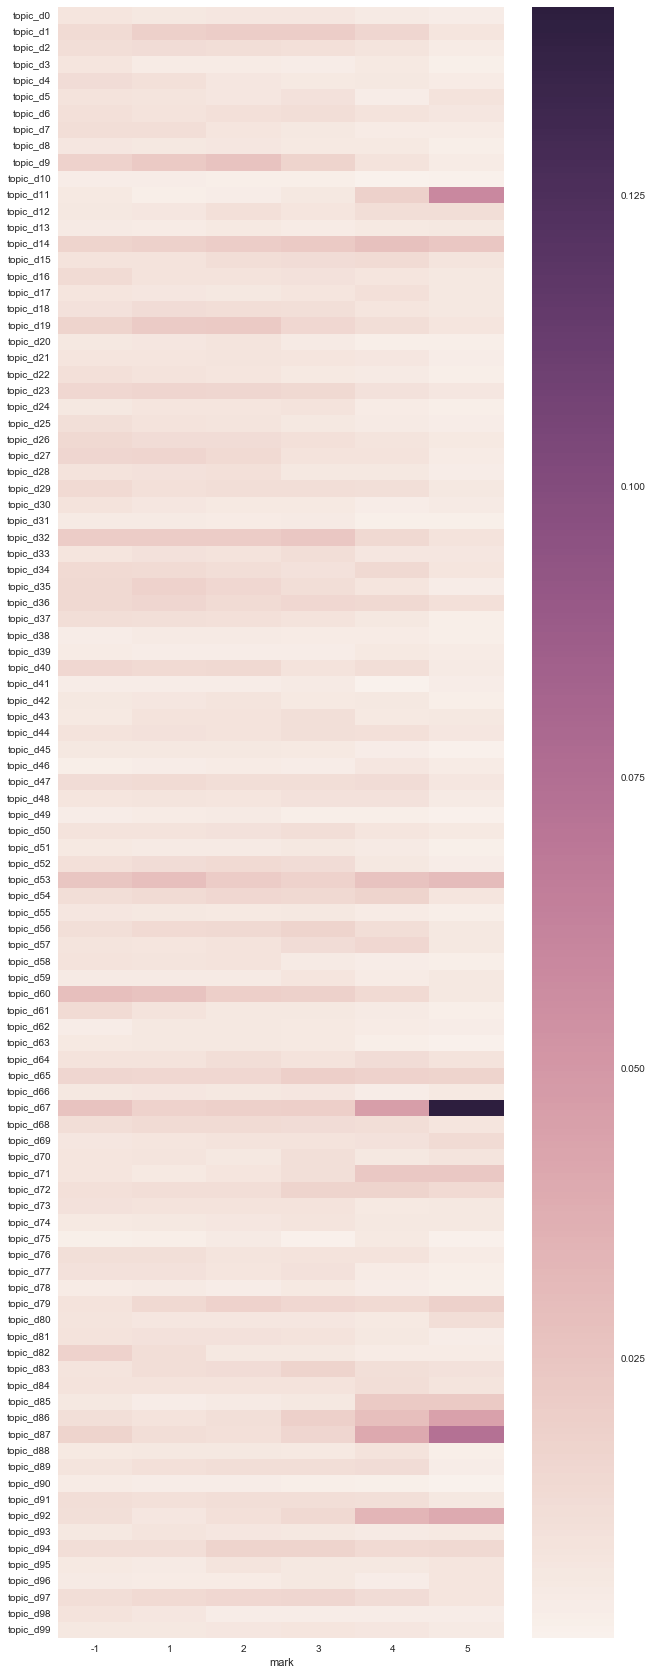

In [142]:
theta = model.get_theta()
theta = theta.transpose()[topics_domain]
theta.index = map(int, theta.index)
theta = theta.join(replies.mark)
topic_influence = theta.groupby("mark").sum()
norm = topic_influence.sum(axis=1)
topic_influence = topic_influence.divide(norm, axis=0)
plt.figure(figsize=(10, 30))
heatmap(topic_influence.transpose())

Сохраним ТМ на диск

In [233]:
model.save(FOLDER_DATA + "model")

## Добавим словарь тональностей

Воспользуемся общедоступным словарем тональностей [LINES CROWD](http://linis-crowd.org)

Каждое слово в словаре имеет несколько оценок тональности, выражаемых целыми числами от -2 до 2.

Сделаем лемматизацию словаря для того чтобы множество его слов солгасовывалось со словарем тематической модели.

In [143]:
sentiment = pd.read_excel(SENTIMENT_PATH, 
                          header=None)
mystem = Mystem()
sentiment[0] = sentiment[0].apply(lambda word: lemmatize(word, mystem)[0])
sentiment.head(10)

,0,1
0,абажур,0
1,абажур,0
2,абажур,-1
3,абориген,-1
4,абориген,-1
5,абориген,0
6,аборт,-2
7,аборт,0
8,аборт,-1
9,аборт,0


Для каждого слова из словаря усредним и отнормируем его оценки тональности.

In [144]:
sentiment = sentiment.groupby(0).mean()
sentiment.columns = ["value"]
sentiment.value /= 2

Отберем тональные слова, встречающиеся в словаре тематической модели.

In [103]:
vocab = getSetFromFile(VOCAB_PATH)
indexes = set(sentiment.index) & vocab
sentiment = sentiment.loc[indexes]
positive = set(sentiment[sentiment.value > 0].index)
negative = set(sentiment[sentiment.value < 0].index)
sentiment_dict = positive | negative
print "Всего тональных слов {}, из них положительной тональности - {}, \
отрицательной - {}".format(sum(sentiment.value != 0), len(positive), len(negative))

Всего тональных слов 1899, из них положительной тональности - 681, отрицательной - 1218


### Разделим словарь на две части: тональные и не тональные слова.

In [104]:
bv.dictionary.save_text(FOLDER_DATA + "all.txt")

Составим тональный словарь. Тональным словам зададим вес согласно словарю, остальным словам зададим вес равный нулю.

In [105]:
ethnic_dict_name = 'sentiment'

num_tokens = 0

dictionary_data = artm.messages.DictionaryData()
with codecs.open(FOLDER_DATA + "all.txt", 'r', 'utf-8') as fin:
    dictionary_data.name = "sentiment"
    fin.next()  # skip comment line
    fin.next()

    for line in fin:
        num_tokens += 1
        line_list = line.split(' ')
        
        token = line_list[0][0: -1]
        class_id = line_list[1][0: -1]
        
        dictionary_data.token.append(token)
        dictionary_data.class_id.append(class_id)
        
        if token in sentiment_dict:
            dictionary_data.token_value.append(sentiment.loc[token].value)  # default value for all modalities
        else:
            dictionary_data.token_value.append(0.0)
        
        dictionary_data.token_tf.append(float(line_list[3][0: -1]))
        dictionary_data.token_df.append(float(line_list[4][0: -1]))
        
        
dictionary_sentiment = artm.Dictionary()
dictionary_sentiment.create(dictionary_data)

dictionary_sentiment.save(dictionary_path=FOLDER_DATA + ethnic_dict_name + ".dict")

dictionary_sentiment.save_text(dictionary_path=FOLDER_DATA + ethnic_dict_name + ".txt")

# os.remove(os.path.join(batches_folder, '{}.txt'.format(dict_name)))

print 'Number of tokens in dictionary: {}'.format(num_tokens)

Number of tokens in dictionary: 11902


Составим словарь с нетональными словами. Тональным словам зададим вес равный нулю, у остальных слов не будем изменять вес.

In [106]:
ethnic_dict_name = 'non_sentiment'

num_tokens = 0

dictionary_data = artm.messages.DictionaryData()
with codecs.open(FOLDER_DATA + "all.txt", 'r', 'utf-8') as fin:
    dictionary_data.name = "sentiment"
    fin.next()  # skip comment line
    fin.next()

    for line in fin:
        num_tokens += 1
        line_list = line.split(' ')
        
        token = line_list[0][0: -1]
        class_id = line_list[1][0: -1]
        
        dictionary_data.token.append(token)
        dictionary_data.class_id.append(class_id)
        
        if token in sentiment_dict:
            dictionary_data.token_value.append(abs(sentiment.loc[token].value))  # default value for all modalities
        else:
            dictionary_data.token_value.append(0.0)
        
        dictionary_data.token_tf.append(float(line_list[3][0: -1]))
        dictionary_data.token_df.append(float(line_list[4][0: -1]))
        
        
dictionary_non_sentiment = artm.Dictionary()
dictionary_non_sentiment.create(dictionary_data)

dictionary_non_sentiment.save(dictionary_path=FOLDER_DATA + ethnic_dict_name + ".dict")

dictionary_non_sentiment.save_text(dictionary_path=FOLDER_DATA + ethnic_dict_name + ".txt")

# os.remove(os.path.join(batches_folder, '{}.txt'.format(dict_name)))

print 'Number of tokens in dictionary: {}'.format(num_tokens)

Number of tokens in dictionary: 11902


In [145]:
# создадим модель с 100 предметными, 10 фоновыми и тонльными темами

In [146]:
model_sentiment = artm.ARTM(topic_names=topics_sentiment + topics_domain + topics_background, dictionary=bv.dictionary,
                  theta_columns_naming="title",
                  num_document_passes=1, cache_theta=True,reuse_theta=True)

In [147]:
# добавим метрики качества

Потребуем от модели, чтобы тональные слова собрались в двух темах. Для этого будем сглаживать тональные темы по тональному словарю и разреживать предметные по словарю нетональных слов. 

In [148]:
model_sentiment.regularizers.add(artm.SmoothSparsePhiRegularizer(name="sentiment_positive",
                                                                 dictionary=dictionary_sentiment,
                                                                 topic_names=topics_sentiment[0], 
                                                                  tau=1000))
model_sentiment.regularizers.add(artm.SmoothSparsePhiRegularizer(name="sentiment_negative",
                                                                 dictionary=dictionary_sentiment,
                                                                   topic_names=topics_sentiment[1], 
                                                                   tau=-1000))
model_sentiment.regularizers.add(artm.SmoothSparsePhiRegularizer(name="non_sentiment",
                                                                 dictionary=dictionary_non_sentiment,
                                                                topic_names=topics_domain + topics_background,
                                                                tau=-10000))

In [149]:
# сделаем 40 итерации по коллекции

Модель сошлась, теперь можно включать регуляризатор декорреляции.

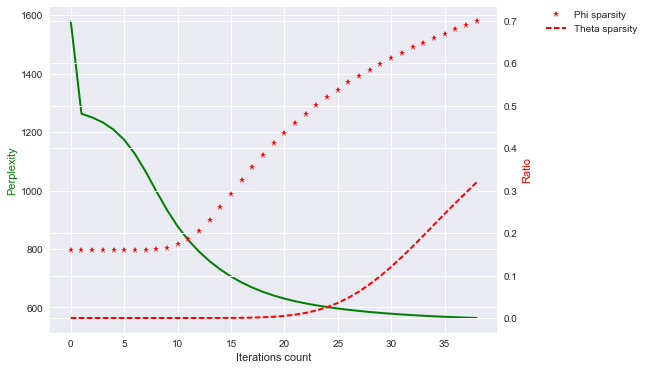

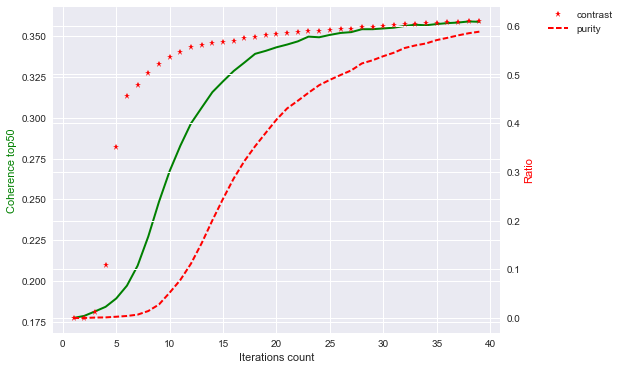

In [150]:
plot(model_sentiment)

Посмторим на топ-токены, тональные слова собрались в первых двух темах.

In [151]:
printTopics(model_sentiment, topics_sentiment + topics_domain)

topic_pos:[70/1013] сотрудник смочь писать нужный вернуть помогать одобрять страховка подписывать возможность спасибо новый надеяться добрый хороший покупка открытие наш рекомендовать поддержка возврат довольный понравиться решаться встречать удобный нравиться всегда помощь искать мобильный интересный касса бонус впечатление приятный желать исправлять радовать внимание захотеть доход вежливый согласный уважение подождать здравствовать интересовать важный разный россия увеличивать благодарность надежда привозить любить отзывчивый компетентный подпись правда полностью единственный сделка извиняться гениальный нормальный стараться уметь обязательство положительный
topic_neg:[70/1215] указывать пользоваться заявление отказываться проблема оставлять много пытаться списывать выясняться разбираться срок начинаться проводить отказ передавать никакой претензия лицо заявлять сидеть потратить забирать занимать ошибка выплачивать заплатить долг продолжать нарушать забывать отдавать конец попытка ш

In [152]:
model_sentiment.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SmoothPhi', tau=0.02, topic_names=topics_background))
model_sentiment.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SmoothTheta', tau=0.02, topic_names=topics_background))
model_sentiment.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorDomain',
                                                       tau=5000000, topic_names=topics_domain))
model_sentiment.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorSentiment',
                                                       tau=5000, topic_names=topics_sentiment))

Если вы вдргу хотите поменять параметры регуляризатора, то можно не посредственно изменить желаемы параметр.

In [153]:
model_sentiment.regularizers['DecorrelatorSentiment'].tau = 500000

In [154]:
model_sentiment.fit_offline(batch_vectorizer=bv, num_collection_passes=10)

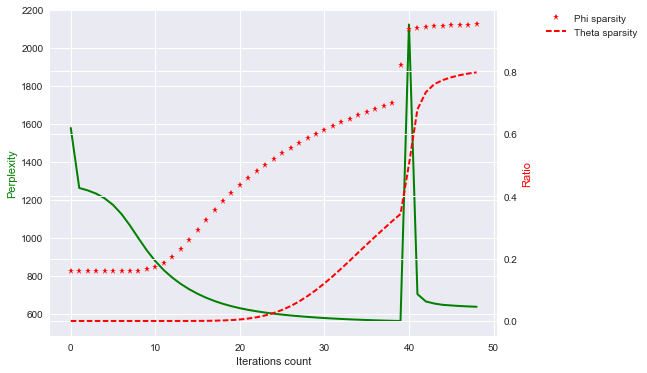

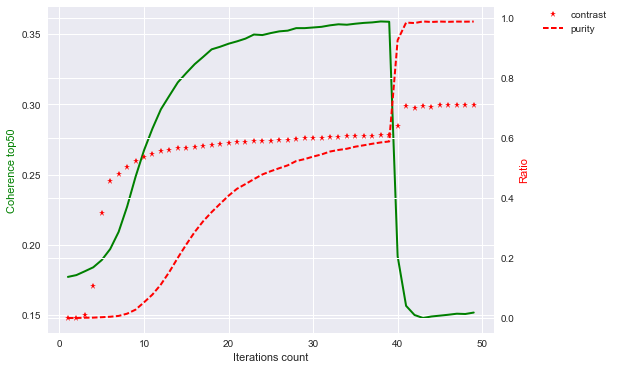

In [155]:
plot(model_sentiment)

In [156]:
printTopics(model_sentiment, topics_sentiment + topics_domain)

topic_pos:[70/802] сотрудник смочь писать нужный вернуть помогать одобрять страховка подписывать возможность спасибо новый надеяться добрый хороший покупка открытие наш рекомендовать поддержка возврат довольный понравиться решаться встречать удобный нравиться всегда помощь искать мобильный интересный касса бонус впечатление приятный желать исправлять радовать внимание захотеть доход вежливый согласный уважение подождать здравствовать интересовать важный разный россия увеличивать благодарность надежда привозить любить отзывчивый компетентный подпись правда полностью единственный сделка извиняться гениальный нормальный стараться уметь обязательство положительный
topic_neg:[70/1215] указывать пользоваться заявление отказываться проблема оставлять много пытаться списывать выясняться разбираться срок начинаться проводить отказ передавать никакой претензия лицо заявлять сидеть потратить забирать занимать ошибка выплачивать заплатить долг продолжать нарушать забывать отдавать конец попытка шт

Как видим тональные слова сконцентрировались в тональных темах, что и требовалось от модели.

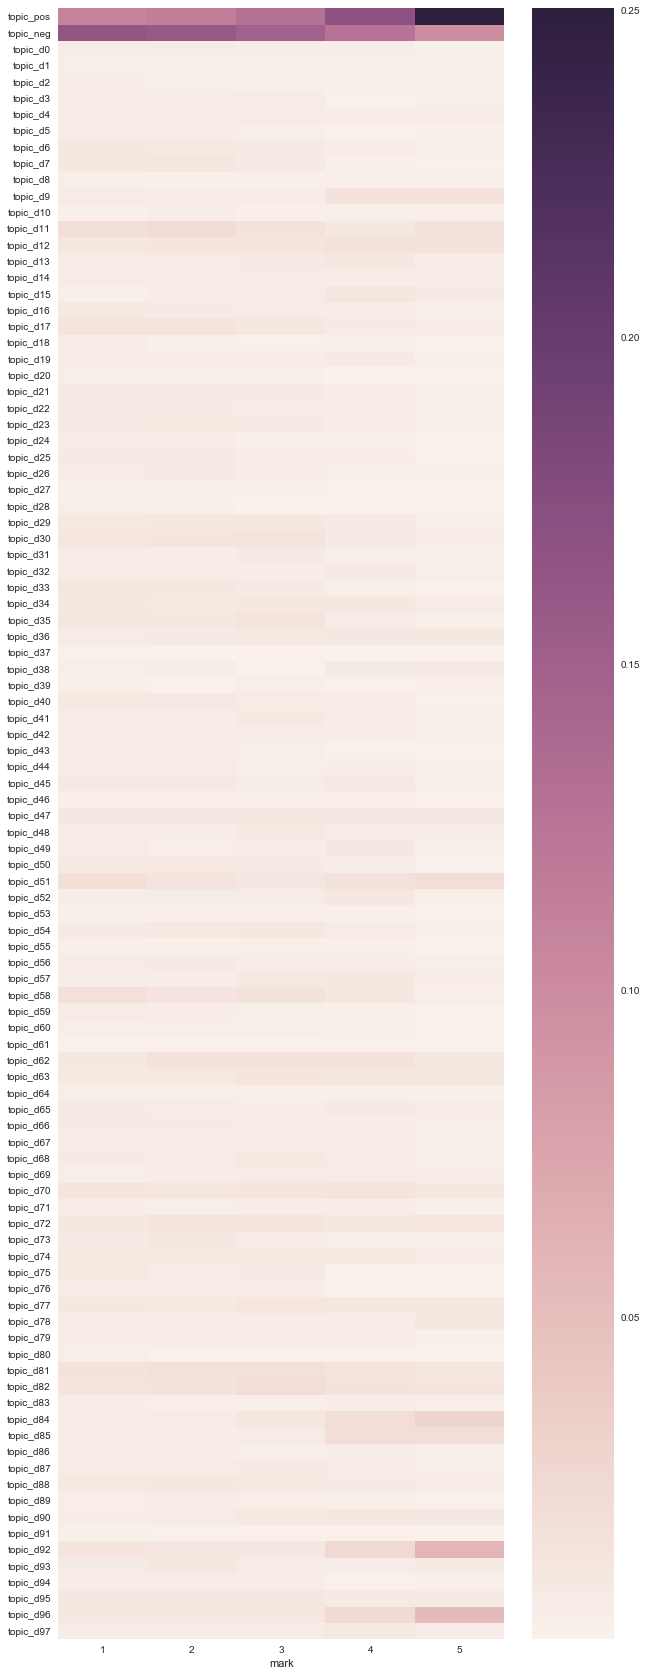

In [157]:
theta = model_sentiment.get_theta()
theta = theta.transpose()[topics_sentiment + topics_domain]
theta.index = map(int, theta.index)
theta = theta.join(replies.mark)
theta = theta[theta.mark != -1]
topic_influence = theta.groupby("mark").sum()
norm = topic_influence.sum(axis=1)
topic_influence = topic_influence.divide(norm, axis=0)
plt.figure(figsize=(10, 30))
heatmap(topic_influence.transpose())

Вытянем матрицу $\Theta$ из модели. Проигнорируем фоновые темы и перенормируем матрицу.

In [158]:
theta = model_sentiment.get_theta().loc[topics_sentiment + topics_domain]
theta = theta.divide(theta.sum(axis=0), axis=1)
banks = { bank: index for index, bank in enumerate(replies.bank.unique())}

Оценим тональности $s$ предметной темы $t$ для банка $b$. 

$p(t_s | b, t) =   \frac{1}{|D|}\sum_{d \in D} p(t = t_s | b, d) * p(t | b, d) [p(t = t_s | b, d) > 0.1, p(t | b, d) > 0.1]$,

где $D$ --- множество отзывов.

P.S.
- тут явные проблемы с обозначениями/вероятностным пространством. Оставим эту формулу в качестве эвристики для лучшего понимания.
- можно код переписать слишком неоптимально.

In [159]:
bank_topic_sentiment = np.zeros((len(banks), len(topics_domain), 3))
for index, row in tqdm_notebook(theta.transpose().iterrows()):
    positive = row.topic_pos
    negative = row.topic_neg
    if positive > 0.1 or negative > 0.1:
        selected = row[topics_domain][row > 0.1]
        if len(selected) > 0:
            for topic in selected.index:
                bank = banks[replies.loc[int(index)].bank]
                topic_influence = selected[topic]
                topic = int(topic.split("_")[1][1:])
                sentiment = np.argmax(row[topics_sentiment])
                if sentiment == "topic_pos":
                    sentiment = 0
                    sentiment_value = positive
                else:
                    sentiment = 1
                    sentiment_value = negative
                bank_topic_sentiment[bank, topic, sentiment] += sentiment_value * topic_influence
                bank_topic_sentiment[bank, topic, 2] += 1

Оценим положительность окраса предметной темы $t$ для банка $b$ если число отзывов > 10

## $\frac{p(t_{+} | b, t)}{p(t_{+} | b, t) + p(t_{-} | b, t)}$

In [160]:
bank_topic = np.zeros((len(banks), len(topics_domain)))
not_null_columns = []
for i, bank in enumerate(bank_topic_sentiment):
    not_null = False
    for j, topic in enumerate(bank):
        if topic[2] > 10:
            bank_topic[i, j] = float(topic[0]) / (topic[0] + topic[1])
            not_null = True
        else:
            bank_topic[i, j] = float("nan")
    not_null_columns.append(not_null)
bank_topic = bank_topic[not_null_columns]

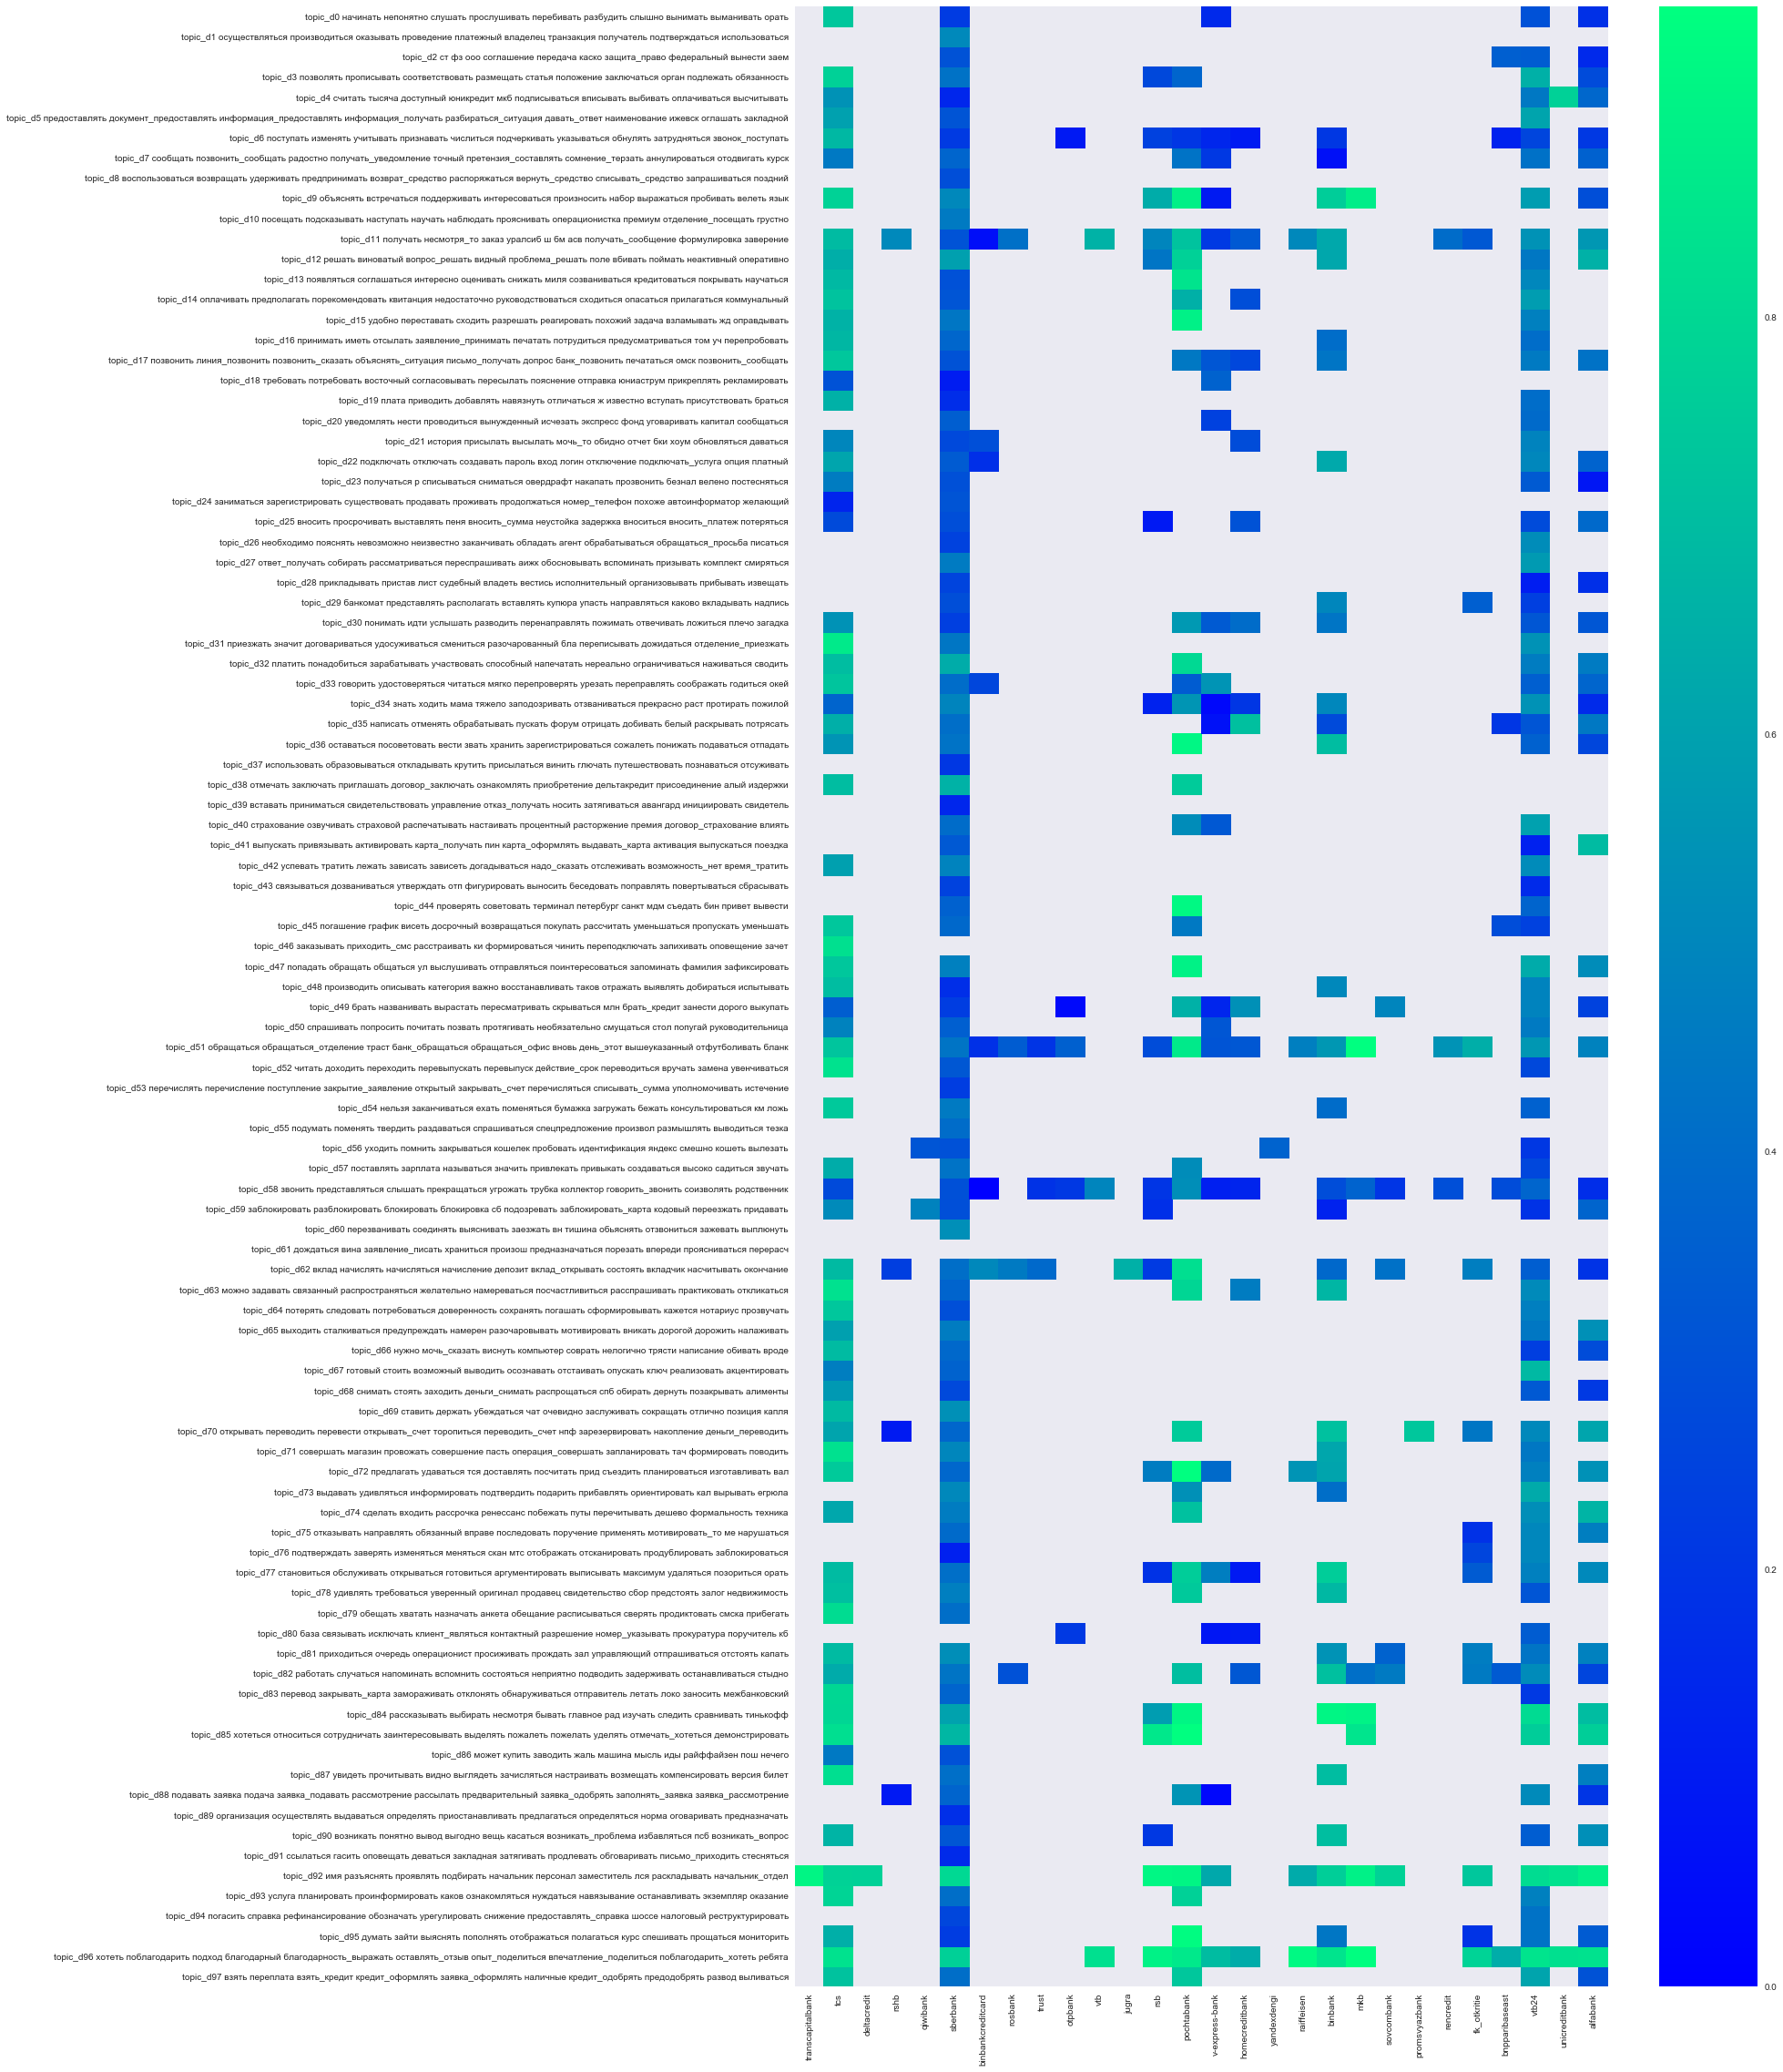

In [161]:
plt.figure(figsize=(20, 40))
data_bank = pd.DataFrame(bank_topic.transpose())
data_bank.columns = [key for key, value in sorted(banks.items(), key=lambda x:x[1]) if not_null_columns[value]]
description = []
Phi = model_sentiment.get_phi()
for i, topic in enumerate(topics_domain):
        topicSeries = Phi[topic].sort_values(ascending=False)[:10]
        indexes = topicSeries > 0
        result = topicSeries[indexes].index
        description.append(topic + " " + " ".join(result))
data_bank.index = description
heatmap(data_bank , cmap="winter")
plt.savefig("banks_sentiment_replies.png")

In [125]:
printTopics(model_sentiment, topics=topics_sentiment + topics_domain, print_file=True)

topic_pos:[70/835] имя сотрудник смочь писать нужный вернуть помогать одобрять страховка подписывать возможность спасибо новый надеяться добрый хороший покупка открытие наш рекомендовать поддержка возврат довольный понравиться решаться встречать удобный нравиться всегда помощь искать мобильный интересный касса бонус впечатление приятный желать исправлять радовать внимание захотеть доход вежливый согласный уважение подождать здравствовать интересовать важный разный россия увеличивать благодарность надежда привозить любить отзывчивый компетентный подпись правда полностью единственный сделка извиняться гениальный нормальный стараться уметь обязательство
topic_neg:[70/1215] указывать пользоваться заявление отказываться проблема оставлять много пытаться списывать выясняться разбираться срок начинаться проводить отказ передавать никакой претензия лицо заявлять сидеть потратить забирать занимать ошибка выплачивать заплатить долг продолжать нарушать забывать отдавать конец попытка штраф обманы

In [234]:
model_sentiment.save(FOLDER_DATA + "model_sentiment")

## WNTM

In [162]:
PATH_TO_WW_VW = FOLDER_DATA + 'ww_vw.txt'
FOLDER_BATCHES_WW = FOLDER_DATA + 'batches_wntm/'

Подготовим батчи

In [163]:
checkDirectory(FOLDER_BATCHES_WW)
bv_ww = #подготовим батчи

Добавим метрики качества

In [287]:
createTopics(domain_n=100, background_n=10, sentiment=True)

Инициализируем модель

In [298]:
model_ww = artm.ARTM(topic_names=topics_sentiment + topics_domain + topics_background, dictionary=bv.dictionary,
                  theta_columns_naming="title",
                  num_document_passes=1, cache_theta=True,reuse_theta=True)
add_scores(model_ww)

In [299]:
dictionary_sentiment = artm.Dictionary(dictionary_path=FOLDER_DATA + "sentiment.dict")
dictionary_non_sentiment = artm.Dictionary(dictionary_path=FOLDER_DATA + "non_sentiment.dict")

In [300]:
model_ww.regularizers.add(artm.SmoothSparsePhiRegularizer(name="sentiment_positive",
                                                                 dictionary=dictionary_sentiment,
                                                                 topic_names=topics_sentiment[0], 
                                                                  tau=100))
model_ww.regularizers.add(artm.SmoothSparsePhiRegularizer(name="sentiment_negative",
                                                                 dictionary=dictionary_sentiment,
                                                                   topic_names=topics_sentiment[1], 
                                                                   tau=-100))
model_ww.regularizers.add(artm.SmoothSparsePhiRegularizer(name="non_sentiment",
                                                                 dictionary=dictionary_non_sentiment,
                                                                topic_names=topics_domain + topics_background,
                                                                tau=-1000))

In [306]:
model_ww.fit_offline(batch_vectorizer=bv_ww, num_collection_passes=10)

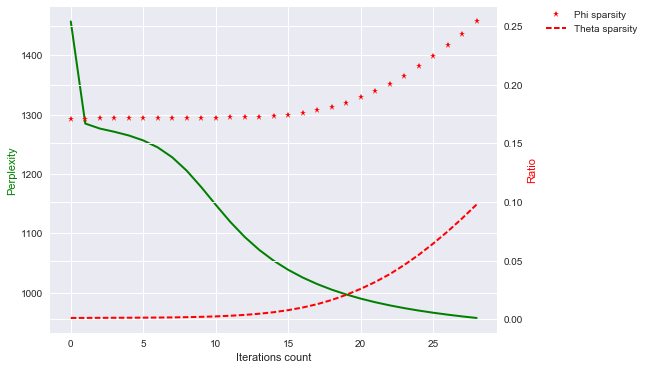

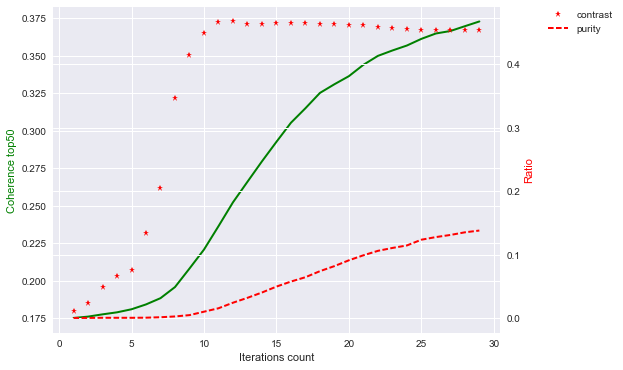

In [307]:
plot(model_ww)

In [308]:
printTopics(model_ww, topics_sentiment + topics_domain)

topic_pos:[70/10100] одобрять помогать проблема новый надеяться спасибо открытие отказ проводить покупка забирать возврат рекомендовать поддержка хороший оставлять имя занимать заявлять наш писать передавать разбираться понравиться встречать долг сделка сотрудник довольный решаться пытаться начинаться искать возможность помощь желать подождать вернуть много здравствовать удобный интересный отказываться нравиться никакой выплачивать согласный заплатить всегда интересовать добрый мобильный разный указывать доход процедура внимание нужный смочь руководитель увеличивать забывать жить касса срок бонус подпись подписывать отдавать безопасность
topic_neg:[70/10565] разбираться претензия начинаться продолжать проблема попытка нарушать потратить штраф ошибка пытаться заявлять никакой жалоба заплатить нарушение долг отсутствовать оставлять забывать выплачивать отдавать обманывать набирать заставлять допускать касса впечатление передавать повторяться занимать угроза записывать превышать очередной

In [309]:
model_ww.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SmoothPhi', tau=0.02, topic_names=topics_background))
model_ww.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SmoothTheta', tau=0.02, topic_names=topics_background))
model_ww.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorDomain',
                                                       tau=500000, topic_names=topics_domain))
model_ww.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorSentiment',
                                                       tau=50000, topic_names=topics_sentiment))

In [313]:
model_ww.fit_offline(batch_vectorizer=bv_ww, num_collection_passes=10)

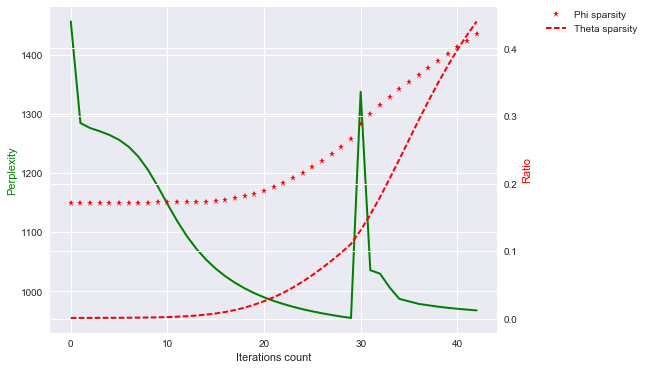

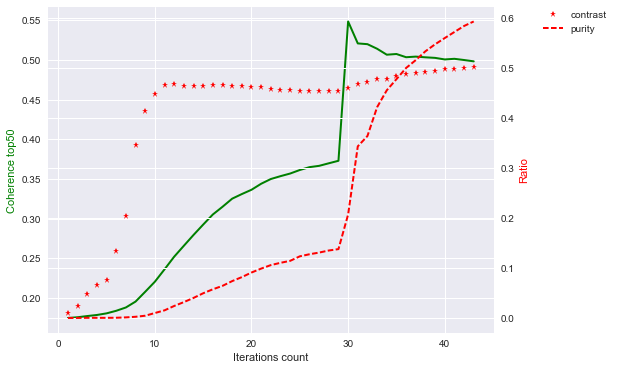

In [314]:
plot(model_ww)

In [315]:
printTopics(model_ww, topics_sentiment + topics_domain)

topic_pos:[70/8294] банк указывать имя одобрять проблема помогать работать хотеть обращаться обслуживание надеяться новый просить отказ спасибо мочь оставлять открытие проводить предлагать получать забирать покупка занимать смочь заявлять возврат наш хороший являться рекомендовать поддержка приходить возникать разбираться встречать то начинаться нет передавать понравиться давать искать сделка решаться работа клиент вернуть этот довольный весь можно желать помощь никакой подождать нужный отвечать вклад касса выплачивать возможность здравствовать удобный писать интересный нравиться жить иметь доход
topic_neg:[70/8551] разбираться претензия начинаться продолжать попытка нарушать долг указывать ошибка штраф заплатить потратить жалоба нарушение отсутствовать проблема считать забывать никакой обманывать заявлять набирать выплачивать допускать отдавать заставлять повторяться угроза превышать очередной записывать удалять персональный доказывать плакать взыскание впечатление оставлять результат

In [268]:
PATH_TO_WW_SENTENCES = FOLDER_DATA + 'vw_sentences.txt'
FOLDER_BATCHES_SENTENCES = FOLDER_BATCHES + 'sentences/'
bv_sentences = artm.BatchVectorizer(data_path=PATH_TO_WW_SENTENCES, data_format='vowpal_wabbit', batch_size=10000,
                                        target_folder=FOLDER_BATCHES_SENTENCES)

In [316]:
theta = model_ww.transform(bv_sentences).loc[topics_sentiment + topics_domain]
theta = theta.divide(theta.sum(axis=0), axis=1)
banks = { bank: index for index, bank in enumerate(replies.bank.unique())}

In [320]:
bank_topic_sentiment = np.zeros((len(banks), len(topics_domain), 3))
for index, row in tqdm_notebook(theta.transpose().iterrows()):
    positive = row.topic_pos
    negative = row.topic_neg
    if positive > 0.1 or negative > 0.1:
        selected = row[topics_domain][row > 0.1]
        if len(selected) > 0:
            for topic in selected.index:
                bank = banks[replies.loc[sentences_replies.loc[int(index)].reply_id].bank]
                topic_influence = selected[topic]
                topic = int(topic.split("_")[1][1:])
                sentiment = np.argmax(row[topics_sentiment])
                if sentiment == "topic_pos":
                    sentiment = 0
                    sentiment_value = positive
                else:
                    sentiment = 1
                    sentiment_value = negative
                bank_topic_sentiment[bank, topic, sentiment] += sentiment_value * topic_influence
                bank_topic_sentiment[bank, topic, 2] += 1

In [335]:
bank_topic = np.zeros((len(banks), len(topics_domain)))
not_null_columns = []
for i, bank in enumerate(bank_topic_sentiment):
    not_null = False
    for j, topic in enumerate(bank):
        if topic[2] > 10:
            bank_topic[i, j] = float(topic[0]) / (topic[0] + topic[1])
            not_null = True
        else:
            bank_topic[i, j] = float("nan")
    not_null_columns.append(not_null)
bank_topic = bank_topic[not_null_columns]

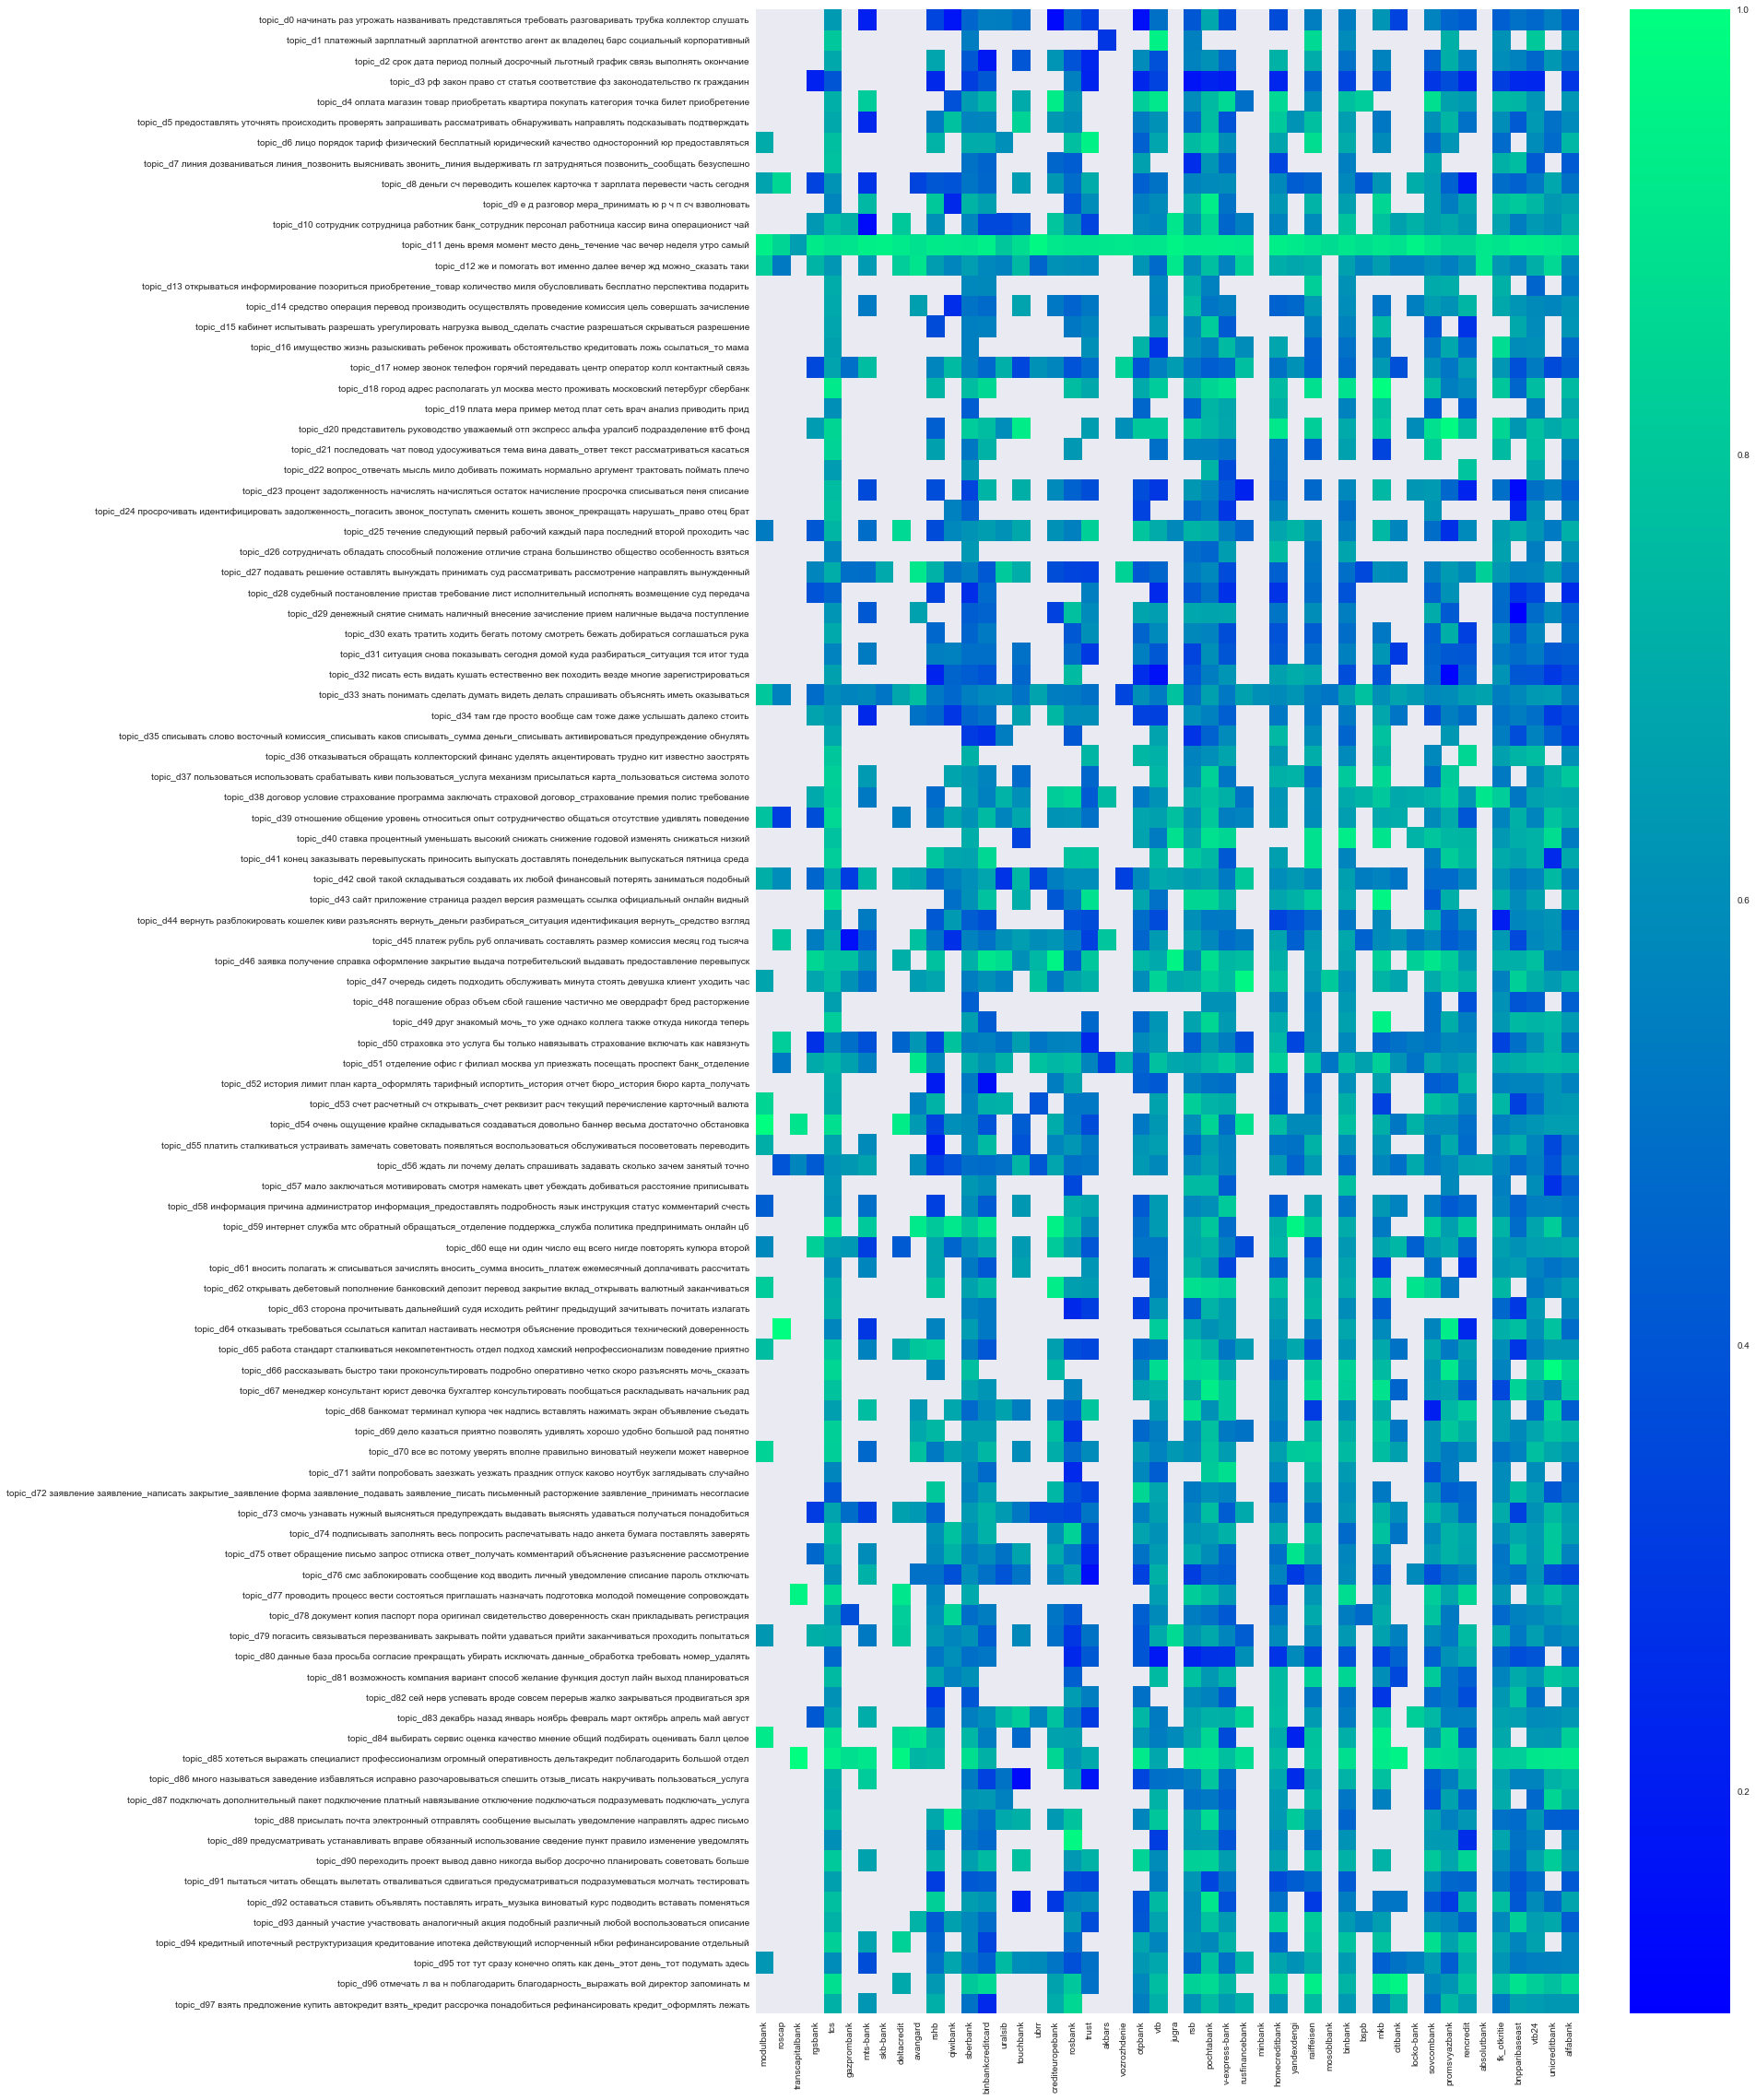

In [336]:
plt.figure(figsize=(20, 40))
data_bank = pd.DataFrame(bank_topic.transpose())
data_bank.columns = [key for key, value in sorted(banks.items(), key=lambda x:x[1]) if not_null_columns[value]]
description = []
Phi = model_ww.get_phi()
for i, topic in enumerate(topics_domain):
        topicSeries = Phi[topic].sort_values(ascending=False)[:10]
        indexes = topicSeries > 0
        result = topicSeries[indexes].index
        description.append(topic + " " + " ".join(result))
data_bank.index = description
heatmap(data_bank , cmap="winter")

In [ ]:
model_ww.save(FOLDER_DATA + "model_ww")

# *Получим свой словарь тональностей

Попробуем получить свой словарь тональностей. Как и ранее, будем считать что тональность отзыва и его оценка согласованы. Предположим, что словам с отрицательной тональностью соответствуют отзывы с оценками от 1 до 3, с отрицательной тональностью оценки 4 и 5. 

Будем считать, что заданы всего 2 темы. Для каждого документа знаем его тему. Если декоррелировать темы то, как раз и получим тональные слова для каждой из тональностей.

In [180]:
PATH_TO_VW_SENTIMENT_NEW = FOLDER_DATA + 'vw_sentiment.txt'
FOLDER_BATCHES_SENTIMENT_NEW = FOLDER_BATCHES + 'sentiment_new/'

In [181]:
bv_sentiment = artm.BatchVectorizer(data_path=PATH_TO_VW_SENTIMENT_NEW, data_format="vowpal_wabbit",
                                    target_folder=FOLDER_BATCHES_SENTIMENT_NEW, gather_dictionary=True)

Создадим тональные темы и одну фоновую

In [182]:
createTopics(domain_n=0, background_n=1, sentiment=True)

In [221]:
model_sentiment_new = artm.ARTM(topic_names=topics_sentiment + topics_background, dictionary=bv_sentiment.dictionary,
                            theta_columns_naming="title",
                  num_document_passes=1, cache_theta=True, reuse_theta=True)

Зададим веса тональностей для документов

In [222]:
indexes = list(replies[replies.mark != -1].index)
doc_titles = map(str, indexes)
doc_coeff = []
marks = [[-1, 100, 0], [-1, 10, 0],  [-1, 1, 0], [10, -1, 0], [100, -1, 0]]
for index, mark in replies.loc[indexes].mark.iteritems():
    doc_coeff.append(marks[mark - 1])

In [223]:
add_scores(model_sentiment_new)

In [224]:
model_sentiment_new.regularizers.add(artm.SmoothSparseThetaRegularizer(name="SST", tau=1000, doc_titles=doc_titles,
                                                                       doc_topic_coef=doc_coeff))

In [225]:
model_sentiment_new.fit_offline(batch_vectorizer=bv_sentiment, num_collection_passes=20)

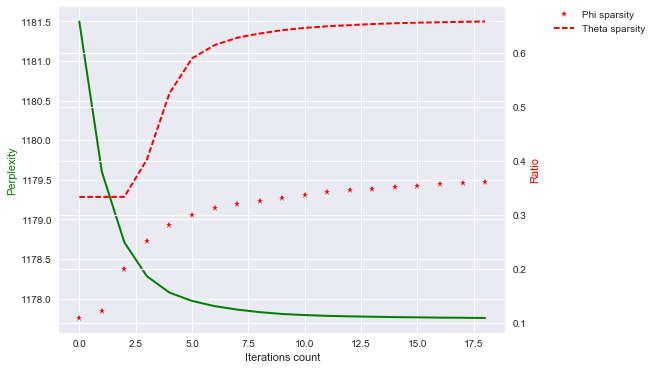

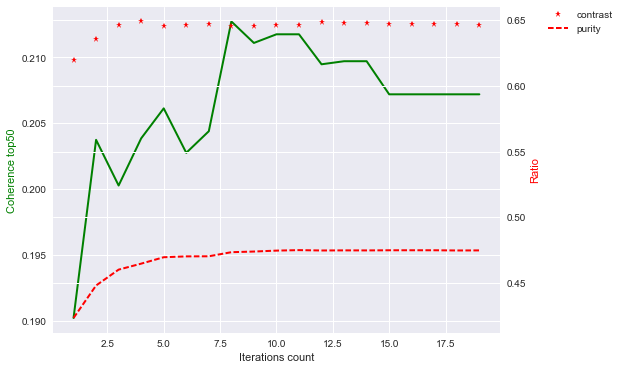

In [226]:
plot(model_sentiment_new)

Декоррелируем тональные темы

In [227]:
model_sentiment_new.regularizers.add(artm.DecorrelatorPhiRegularizer(name="decorrelataion", tau=5e10,
                                                                 topic_names=topics_sentiment))

In [228]:
model_sentiment_new.fit_offline(batch_vectorizer=bv_sentiment, num_collection_passes=10)

Обрежем хвост распределения для темы с негативной тональностью

In [229]:
model_sentiment_new.regularizers.add(artm.SmoothSparsePhiRegularizer("sparsePhi", topic_names=topics_sentiment[1],
                                                                 tau=-100))

In [230]:
model_sentiment_new.fit_offline(batch_vectorizer=bv_sentiment, num_collection_passes=1)

Оценим качество полученного словаря тональностей

In [231]:
printTopics(model_sentiment_new, topics_sentiment, num=500)

topic_pos:[353/353] благодарность_выражать отзывчивый отзывчивость поощрять процветание профессионально доходчиво доброжелательность атмосфера улыбчивый поблагодарить_хотеть дружелюбный внимательность позитивный выражать_хотеть разжевывать чуткий терпеливый доступность отмечать_хотеться угощать терпеливо развивать побуждать выражать_признательность презентация карьерный осложняться сберегать уютно настраиваться экономия модульбанк позитив консультирование доброжелательно тревожить подкупать компенсироваться уютный четкость похвала наслышан нестандартный навык дружить суперставка суета преподносить оптимизировать молиться сглаживать продумывать загашать запоминаться линейка тронуть соображать немаловажный положительный_эмоция уважительный гордиться объединяться быстрота великолепный поощрение простота преображенский переваривать способность мечта ненавязчивый царить блэк заслуга пересчитаться плюшка сущий рождаться ассоциироваться невыносимый подталкивать подстраиваться поучиться любите

# Домашнее задание

## Обязательная часть

1. [Загрузить метаданные о банках](http://www.banki.ru/services/responses/) (Банк, Рейтинг, Средняя оценка, Зачтено отзывов, Решено проблем, Ответов банка)
2. [Выбрать банк](https://docs.google.com/spreadsheets/d/1g1cmBCmN4fWVHV4AR8xLk_N8InZGeFJyFuxK7tUHvx8/edit?usp=sharing). Нельзя выбирать уже кем-то выбранный банк. Нельзя выбирать Тинькофф банк.
3. Провести визуализацию данных.
4. Подготовить vw - файлы
5. Построить ТМ с тональными темами.
6. Построить WNTM c тональными темами
7. Оценить тональности тем для п.5 и п.6

## Бонусная часть

1. Провести анализ отзывов Тинькофф банка
2. Построить тематическую модель на ответах банка(ов)
3. Построить ТМ на заголовках отзывов
4. Использовать отдельную модальность для терминов
5. Загрузить данные с разбивкой по услугам
6. Выгрузить комментарии к отзывам
7. Провести "асессорский" анализ качества тем
8. Загрузить ТМ в инструмент для визуализации. [Пример визуализации](http://visartm.vdi.mipt.ru/)
9. Получить свой словарь тональностей
10. Провести эксперименты с объединёнными словарями

Обязатально приложить ТМ модель.